# **Pima Indians diabetes mellitus classification based on machine learning (ML) algorithms**

In [1]:
# automatsko 're-importanje' modula kada se nešto izmijeni
%load_ext autoreload
%autoreload 2

# podešavanje fonta i margina radi bolje čitkosti
from IPython.display import display, HTML, Math

display(HTML('<link rel="stylesheet" href="https://fonts.googleapis.com/css?family=Source Serif Pro">'))

with open("style.css", "r") as file:
    display(HTML("<style>" + file.read() + "</style>"))

This project tries to reproduce and enhance results from the paper Pima Indians diabetes mellitus classification based on machine learning (ML) algorithms by Victor Chang, Jozenne Bailey, Qianwen Ariel Xu and Zhili Sun. The main purpose of the paper is diagnosing diabetes mellitus from the data obtained by an e-diagnosis system using machine learning algorithms. However, only algorithms that can be interpreted have been employed and used. 

## **1. Data preparation and visualization**

### Import all necessary dependencies

In [2]:
import pandas as pd
import numpy as np
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ks_2samp, anderson
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, plot_confusion_matrix, roc_auc_score, plot_roc_curve, matthews_corrcoef
from sklearn.naive_bayes import GaussianNB
from sklearn.manifold import TSNE
from sklearn import tree
import plotly.express as px
from typing import Dict

In [3]:
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

### Load the dataset

In [4]:
diabetes = pd.read_csv("data/diabetes.csv")

### Start the initial data exploration

In [5]:
# We have 768 data points with 8 independent and 1 dependent variable
diabetes.shape

(768, 9)

In [6]:
# Take a look what are we dealing with
diabetes.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [7]:
# Get info about non-null values and data types.
diabetes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


We can see that there are no categorical variables, the dataset contains only **combination of discrete (BMI and DiabetesPedigreeFunction) and continuous variables (the rest)**.
This makes our life a little bit easier because we don't have to think about **categorical variables** and conversion to the numerical values using e.g **label encoding or one hot encoding**.
Also great thing is that the dataset contains all data, there are **no null or missing values**.

### Descriptive statistics

In [8]:
# First glance at some basic statistical info
diabetes.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


More or less, from the columns values it can be easily concluded **what which feature represents** but let's make it clear so we remove any possible confusion:
- **Pregnancies** -> The number of pregnancies.
- **Glucose** -> Plasma glucose concentration at 2 hours in an oral glucose tolerance test (GTIT).
- **BloodPressure** -> Diastolic Blood Pressure (mm Hg).
- **SkinThickness** -> Triceps skin fold thickness (mm).
- **Insulin** -> 2-Hour Serum insulin (uh/ml).
- **BMI** -> Body mass index (weight in kg/height in m).
- **DiabetesPedigreeFunction** -> A function that scores the likelihood of diabetes based on family history.
- **Age** -> Age (years).
- **Outcome** -> Binary value indicating non-diabetic/diabetic.


In [9]:
# Check if there are some candidates for monotonic attributes
diabetes.nunique()

Pregnancies                  17
Glucose                     136
BloodPressure                47
SkinThickness                51
Insulin                     186
BMI                         248
DiabetesPedigreeFunction    517
Age                          52
Outcome                       2
dtype: int64

It seems that there are **no monotonic attributes**. If we think more about values and what they represent, this makes perfect sense. 
Before diving deeper into visualizing data, let's make sure that all data we have are correct and have some meaning. From the domain experts, it is known that for neither of the features zero values should be present in the dataset and hence, if such exist, can be considered inconsistent. However, from the output of the `describe()` method we see that zero values exist for the **glucose concentration, blood pressure, insulin, BMI and skin fold thickness data**. Let's take a look at how many such examples we are dealing with.

In [10]:
print("Blood pressure is invalid in:", (diabetes.BloodPressure == 0).sum(), "examples. ")
print("Glucose concentration is invalid in:", (diabetes.Glucose == 0).sum(), "examples. ")
print("Insulin is invalid in:", (diabetes.Insulin == 0).sum(), "examples. ")
print("BMI is invalid in:", (diabetes.BMI == 0).sum(), "examples. ")
print("Skin fold thickness is invalid in:", (diabetes.SkinThickness == 0).sum(), "examples. ")

print("----------")
print("In", ((diabetes.BloodPressure == 0) | (diabetes.Glucose == 0) | (diabetes.Insulin == 0) | (diabetes.BMI == 0) | (diabetes.SkinThickness == 0)).sum(), "examples, there is at least one feature invalid. " )

Blood pressure is invalid in: 35 examples. 
Glucose concentration is invalid in: 5 examples. 
Insulin is invalid in: 374 examples. 
BMI is invalid in: 11 examples. 
Skin fold thickness is invalid in: 227 examples. 
----------
In 376 examples, there is at least one feature invalid. 


This means that 48.96% of examples contain some feature invalid which is quite a lot. Because of that, we will **impute the median value on the features that had invalid zero values**. Let's just mention that there are other valid approaches like **imputing the mean and dominant value, removing invalid examples or copying existing values with random noise added**.

### Impute the median value

In [11]:
# Change all zero values with the median values
diabetes_med = diabetes.copy()
diabetes_med.loc[diabetes.BloodPressure == 0, "BloodPressure"] = diabetes.loc[:, "BloodPressure"].median()
diabetes_med.loc[diabetes.Glucose == 0, "Glucose"] = diabetes.loc[:, "Glucose"].median()
diabetes_med.loc[diabetes.Insulin == 0, "Insulin"] = diabetes.loc[:, "Insulin"].median()
diabetes_med.loc[diabetes.BMI == 0, "BMI"] = diabetes.loc[:, "BMI"].median()
diabetes_med.loc[diabetes.SkinThickness == 0, "SkinThickness"] = diabetes.loc[:, "SkinThickness"].median()

Since with this procedure **insulin and skin fold thickness values** are being disrupted, we want to make sure that **the distribution of those features** remained the same.

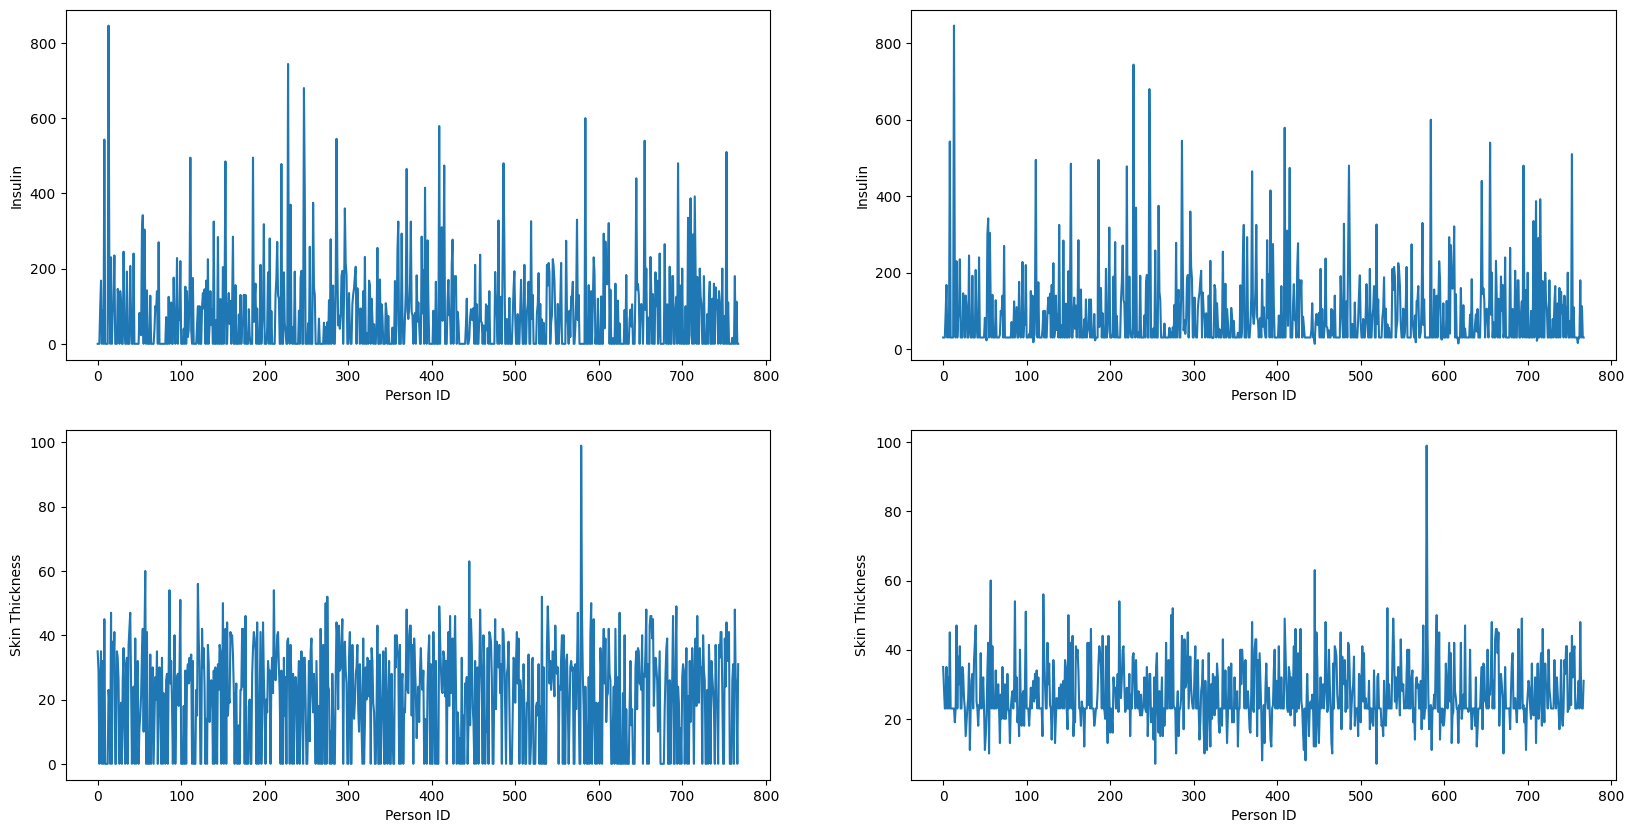

In [12]:
# First extract all values that we will use
ids = [i for i in range(768)]
blood_pressures = diabetes.BloodPressure

# define axes
fig, ax = plt.subplots(2,2, figsize=(20,10)) 

# Insulin distributions comparison
ax[0, 0].plot(ids, diabetes.Insulin)
ax[0, 0].set_xlabel("Person ID")
ax[0, 0].set_ylabel("Insulin")
ax[0, 1].plot(ids, diabetes_med.Insulin)
ax[0, 1].set_xlabel("Person ID")
ax[0, 1].set_ylabel("Insulin")

# Skin thickness distributions comparison
ax[1, 0].plot(ids, diabetes.SkinThickness)
ax[1, 0].set_xlabel("Person ID")
ax[1, 0].set_ylabel("Skin Thickness")
ax[1, 1].plot(ids, diabetes_med.SkinThickness)
ax[1, 1].set_xlabel("Person ID")
ax[1, 1].set_ylabel("Skin Thickness")

plt.show()

Since it is very hard to estimate if the distributions are the same, let's test that out with the two-sample **Kolmogorov-Smirnov test**. Our **null hypothesis** is that the distributions of the original values and with the imputed median values **are the same** for insulin and skin thickness features. 

In [13]:
print(ks_2samp(diabetes.Insulin, diabetes_med.Insulin))
print(ks_2samp(diabetes.SkinThickness, diabetes_med.SkinThickness))

KstestResult(statistic=0.4869791666666667, pvalue=6.2289186348934944e-83)
KstestResult(statistic=0.2955729166666667, pvalue=5.52103149391426e-30)


Since the **p-value is very small**, we have sufficient evidence that two distributions for insulin and skin thickness values are not the same so we **reject the null hypothesis**. Although this is not the ideal scenario, we **continue our survey with the same data** since we cannot afford to lose almost 50% of the data we have.

In [14]:
diabetes = diabetes_med

### Outliers

In this part, we will try to deal with **outliers**. They may exist due to the **variability in the measurements or experimental errors**. One of the best methods to detect outliers is by plotting distribution with the help of the **box-plot**. We will skip age and pregnancies since those value may have their "inner bias" so concluding there are some outliers would be more guessing than finding some meaningful insights.

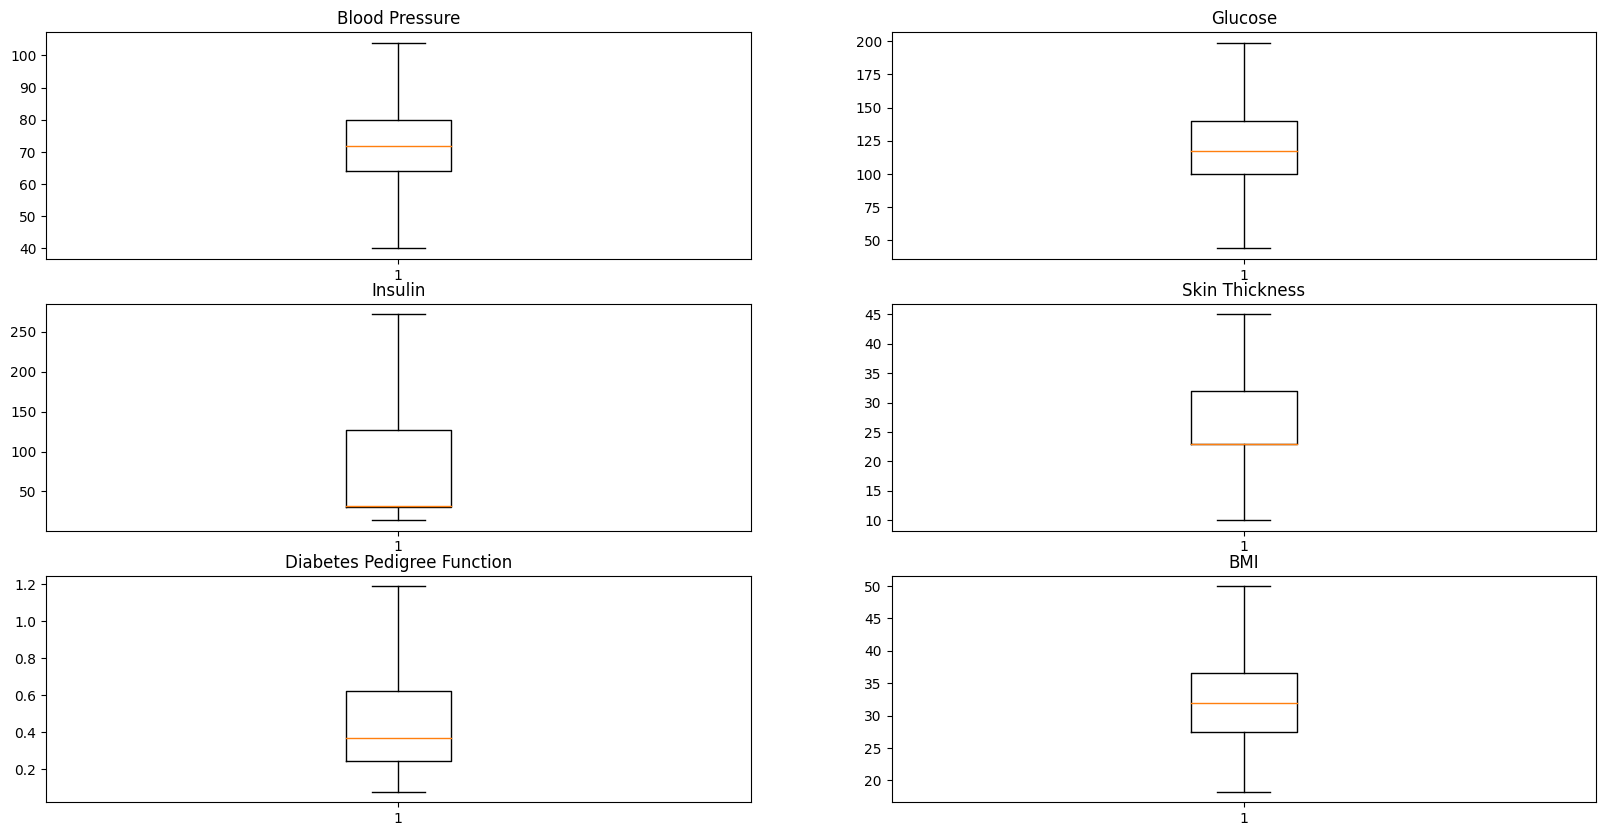

In [15]:
# define the axes
fix, ax = plt.subplots(3, 2, figsize=(20, 10))
# Blood pressure
ax[0, 0].boxplot(diabetes.BloodPressure, showfliers=False)
ax[0, 0].set_title("Blood Pressure")
# Glucose
ax[0, 1].boxplot(diabetes.Glucose, showfliers=False)
ax[0, 1].set_title("Glucose")
# Insulin
ax[1, 0].boxplot(diabetes.Insulin, showfliers=False)
ax[1, 0].set_title("Insulin")
# SkinThickness
ax[1, 1].boxplot(diabetes.SkinThickness, showfliers=False)
ax[1, 1].set_title("Skin Thickness")
# Diabetes pedigree function
ax[2, 0].boxplot(diabetes.DiabetesPedigreeFunction, showfliers=False)
ax[2, 0].set_title("Diabetes Pedigree Function")
# BMI
ax[2, 1].boxplot(diabetes.BMI, showfliers=False)
ax[2, 1].set_title("BMI")
plt.show()

**Box plots** may indicate that outliers exist for the insulin and diabetes pedigree function features. However, thinking about outliers for the insulin feature can be quite misleading since **the median value was imputed** in almost half of the examples so it is logical that the whole distribution is quite centred. Another visualization that can give us insight if there are some outliers is the histogram.




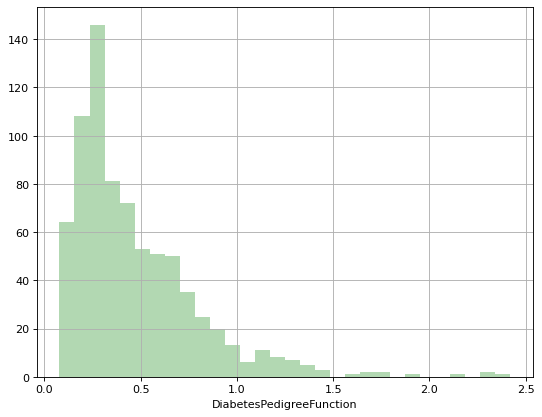

In [16]:
# Use the histogram to detect the outliers in the diabetes pedigree function
figure(figsize=(8, 6), dpi=80)
plt.hist(diabetes.DiabetesPedigreeFunction, bins=30, alpha=0.3, color="green")
plt.grid()
plt.xlabel("DiabetesPedigreeFunction")
plt.show()

Since there are some very small bins far to the right, **it is possible that they represent outliers**. **Standardization of the data and the calculation of the z-scores** can also be used for detecting outliers. We use an assumption that the data comes from the **normal distribution and calculate the probability of seeing such or more extreme value**. Along **goodness-of-fit tests, the QQ plot may be a good indicator of the data normality**. 

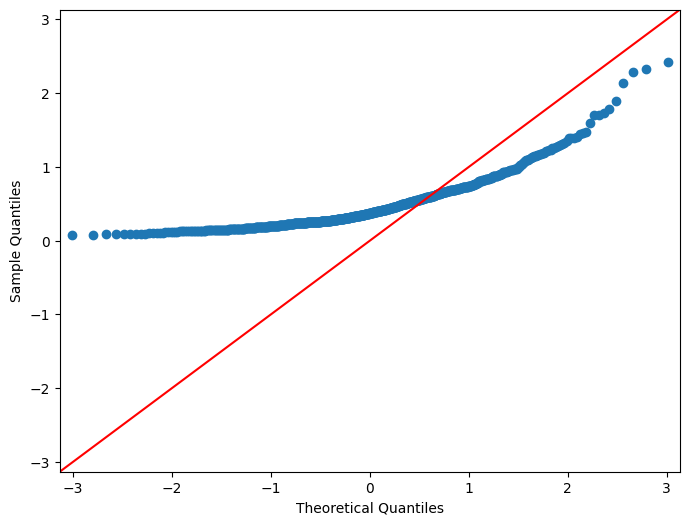

In [17]:
fig = sm.qqplot(diabetes.DiabetesPedigreeFunction, line='45')
fig.set_size_inches(8, 6)
plt.show()

QQ plot indicates that the data doesn't come from the normal distribution. Let's confirm that with the `Anderson-Darling` test with **the null hypothesis that the data comes from the normal distribution**.

In [18]:
anderson(diabetes.DiabetesPedigreeFunction)

AndersonResult(statistic=29.13404800507169, critical_values=array([0.573, 0.653, 0.783, 0.913, 1.086]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

Since **the test statistics is greater than critical values at all significance levels, we reject the null hypothesis that the data comes from the normal distribution**. Unfortunately, the QQ plot and `Anderson-Darling` test gave us a lot of evidence to conclude that the values don't follow a normal distribution. **Hence, we will give up on detecting outliers with the z-scores**.

Since the author didn't take much care about outliers, we will also skip this analysis and leave it maybe for the end and possible improvements.

### Dataset imbalance

Most machine learning algorithms are very sensitive to the situations in which there is significant difference between the number of positive and the number of negative examples. Let's check what is the situation with the diabetes dataset.


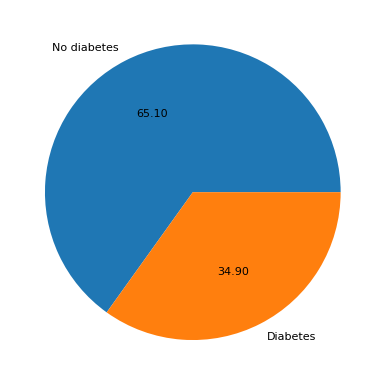

In [19]:
outcomes = diabetes.groupby("Outcome").count().loc[:, "Pregnancies"]
figure(figsize=(8, 6), dpi=80)
plt.pie(outcomes, labels=["No diabetes", "Diabetes"], autopct='%.2f')
plt.show()

Although the imbalance exists, it is not significant and the author also didn't take this into account so without further data preparation, let's explore data in some new ways!

### Feature engineering


The next thing that interests us is whether we can somehow **determine if there are some connections between features** and whether some **feature is a good predictor**. If data points of two features are **aligned this may mean that they are somehow linearly related**. Determining upfront whether some feature is a good predictor is a hard task. We will **plot the distributions of each feature conditioned on the target class** and if they differ, this may be a good indicator that the feature is a good predictor. 

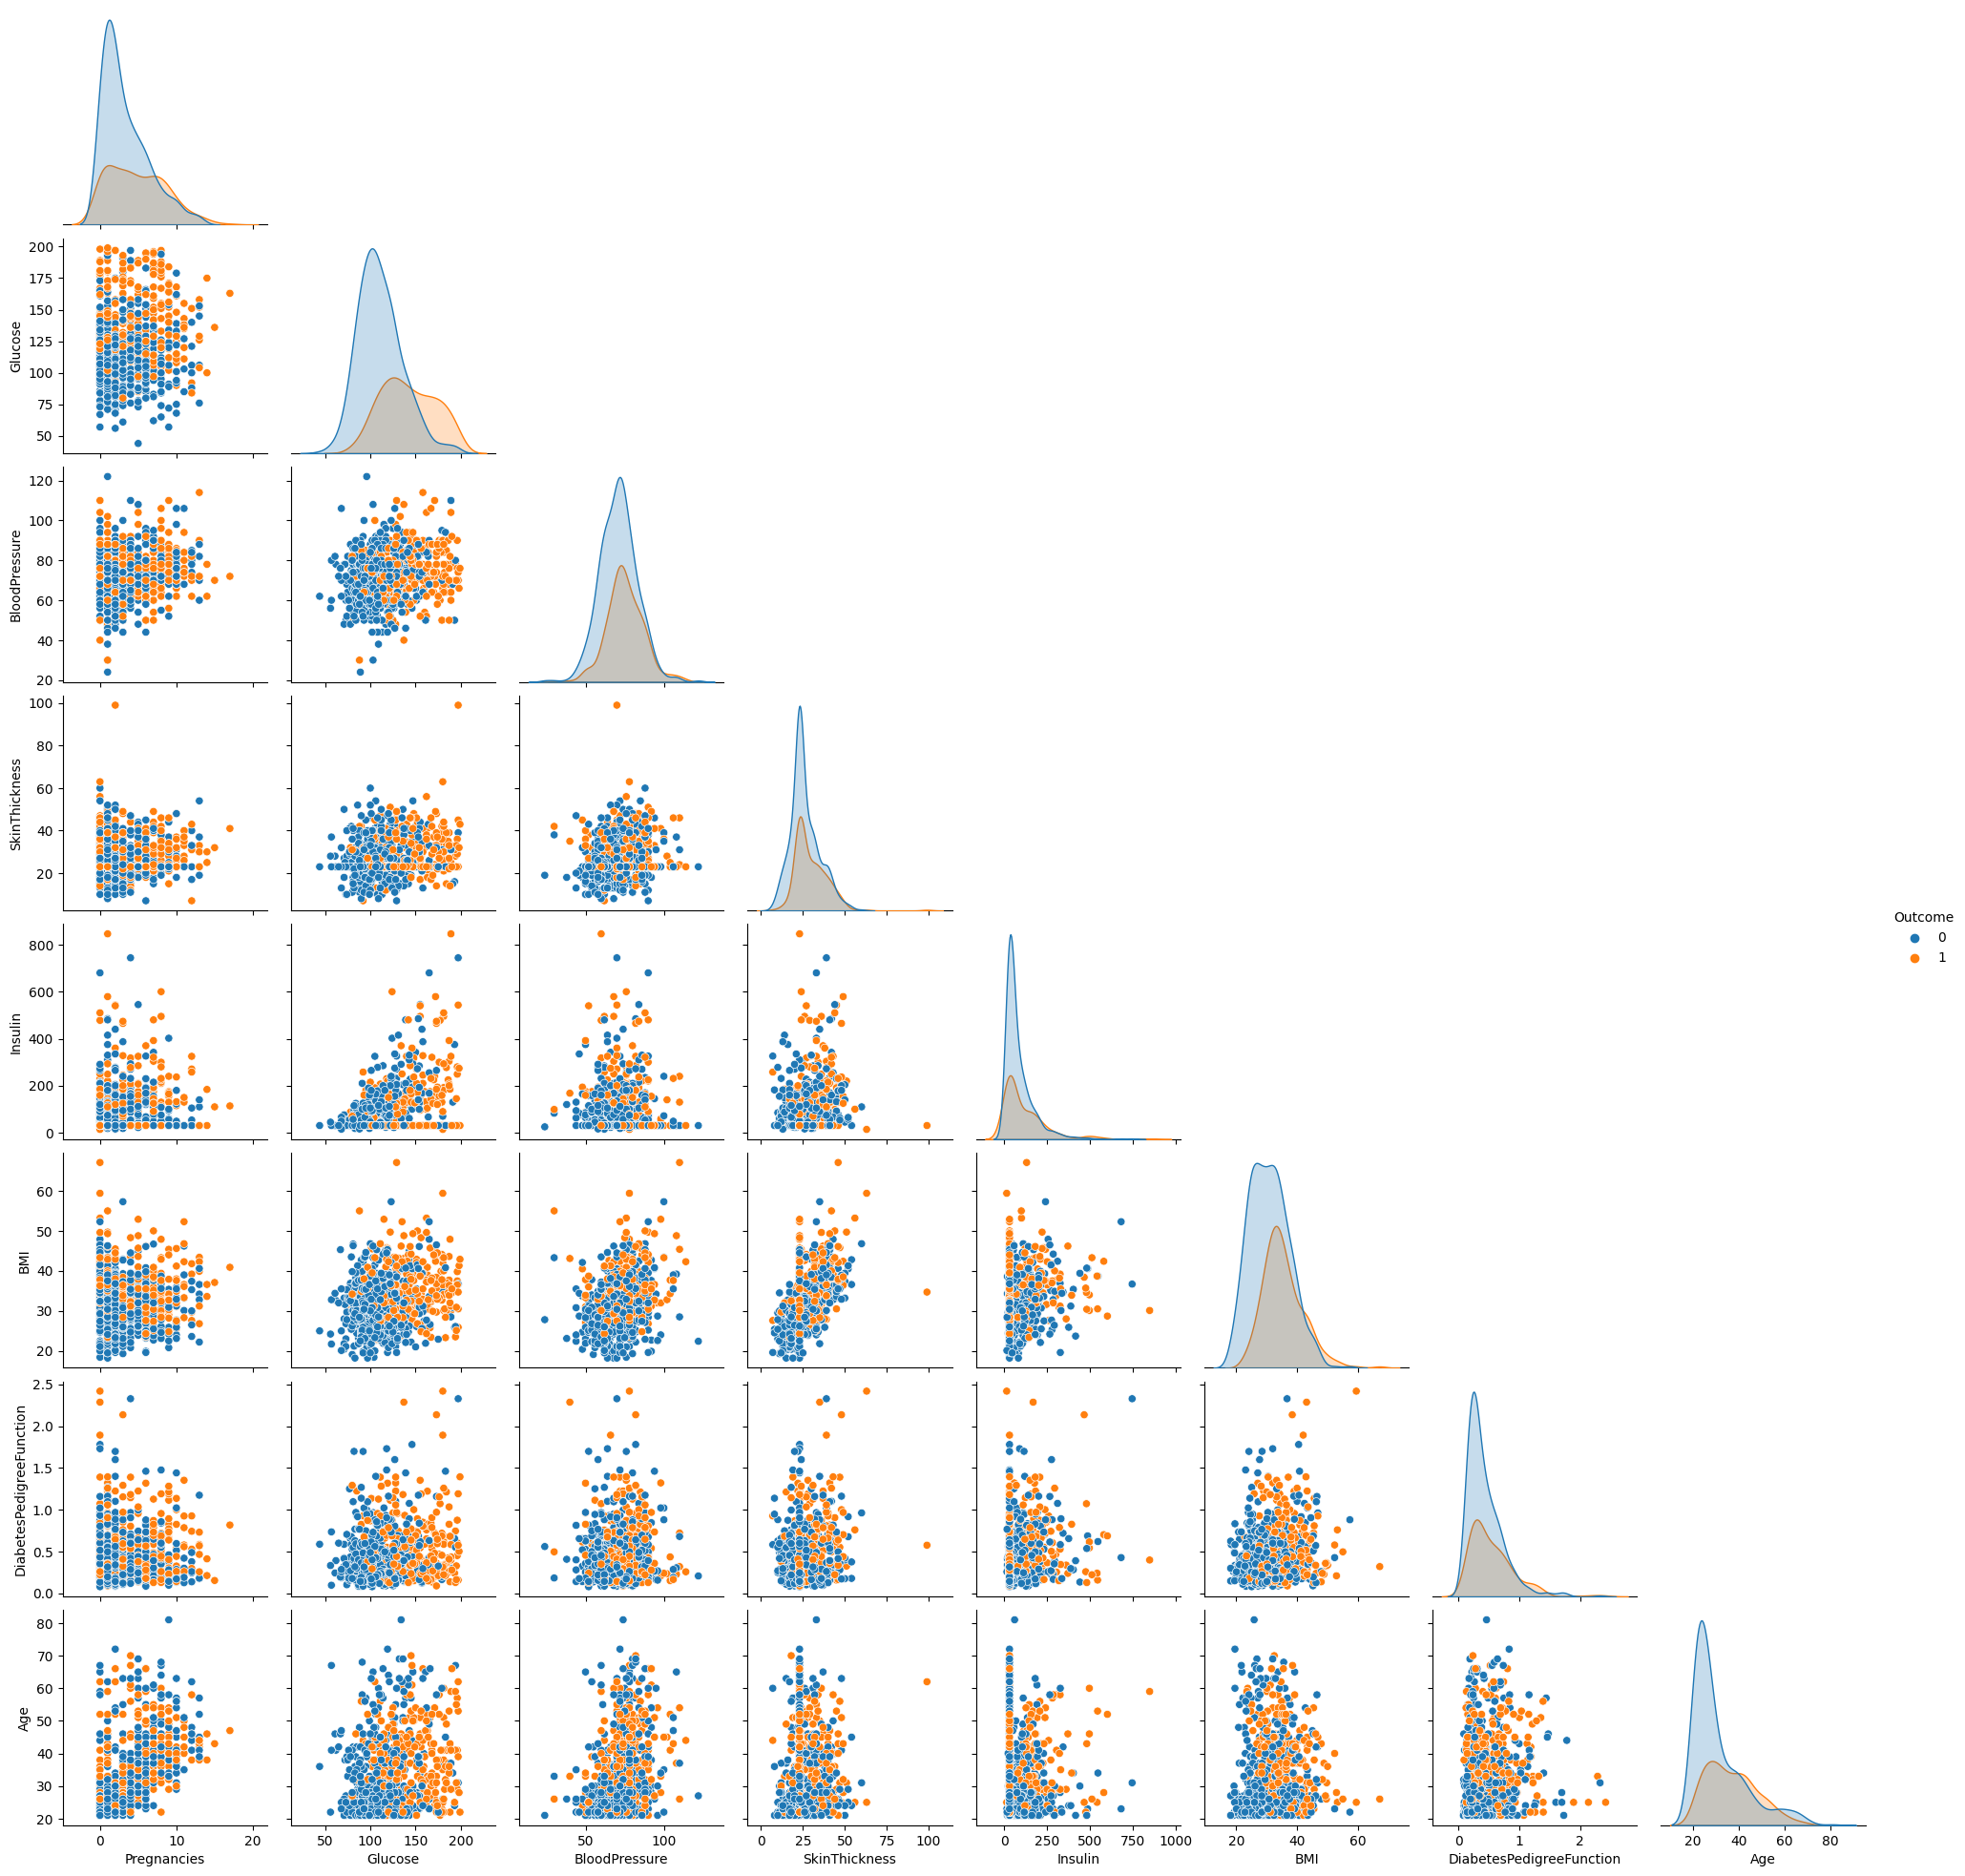

In [20]:
sns.pairplot(diabetes, hue="Outcome", corner=True)
plt.show()

From this output we can conclude that almost **all combinations of features are very scattered and hence not linearly related**. We can only maybe create a hypothesis that the age and the pregnancies are somehow related and this would mean that one of those features should be removed but knowing the context, this doesn't make any sense. **The distributions for each feature differ quite which as we mentioned, may indicate the features are good predictors**. To confirm that combinations of features are scattered let's also **plot the correlation matrix in a form of a heat map**.

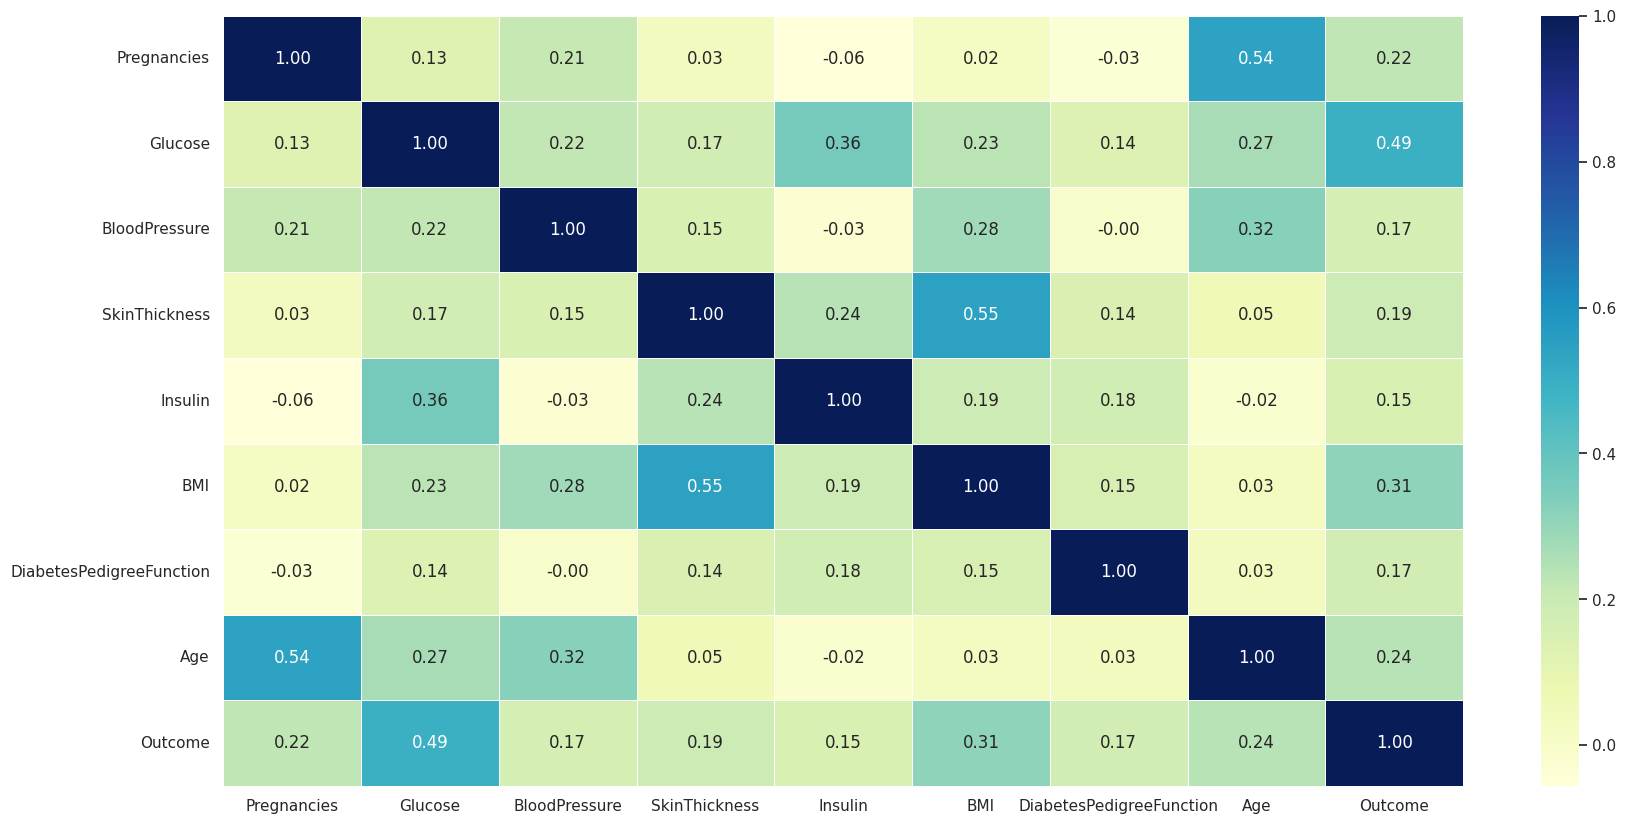

In [21]:
sns.set(rc={'figure.figsize':(20,10)})
sns.heatmap(diabetes.corr(), annot=True, fmt=".2f", cmap="YlGnBu", linewidths=.5)
plt.show()

Indeed, all correlation values are quite low which is why we will continue with all features and conclude that all features bring necessary information in the dataset. The most correlated feature with the outcome is Glucose. Let's visualize values of the Glucose using the combination of the violin and the swarm plot.

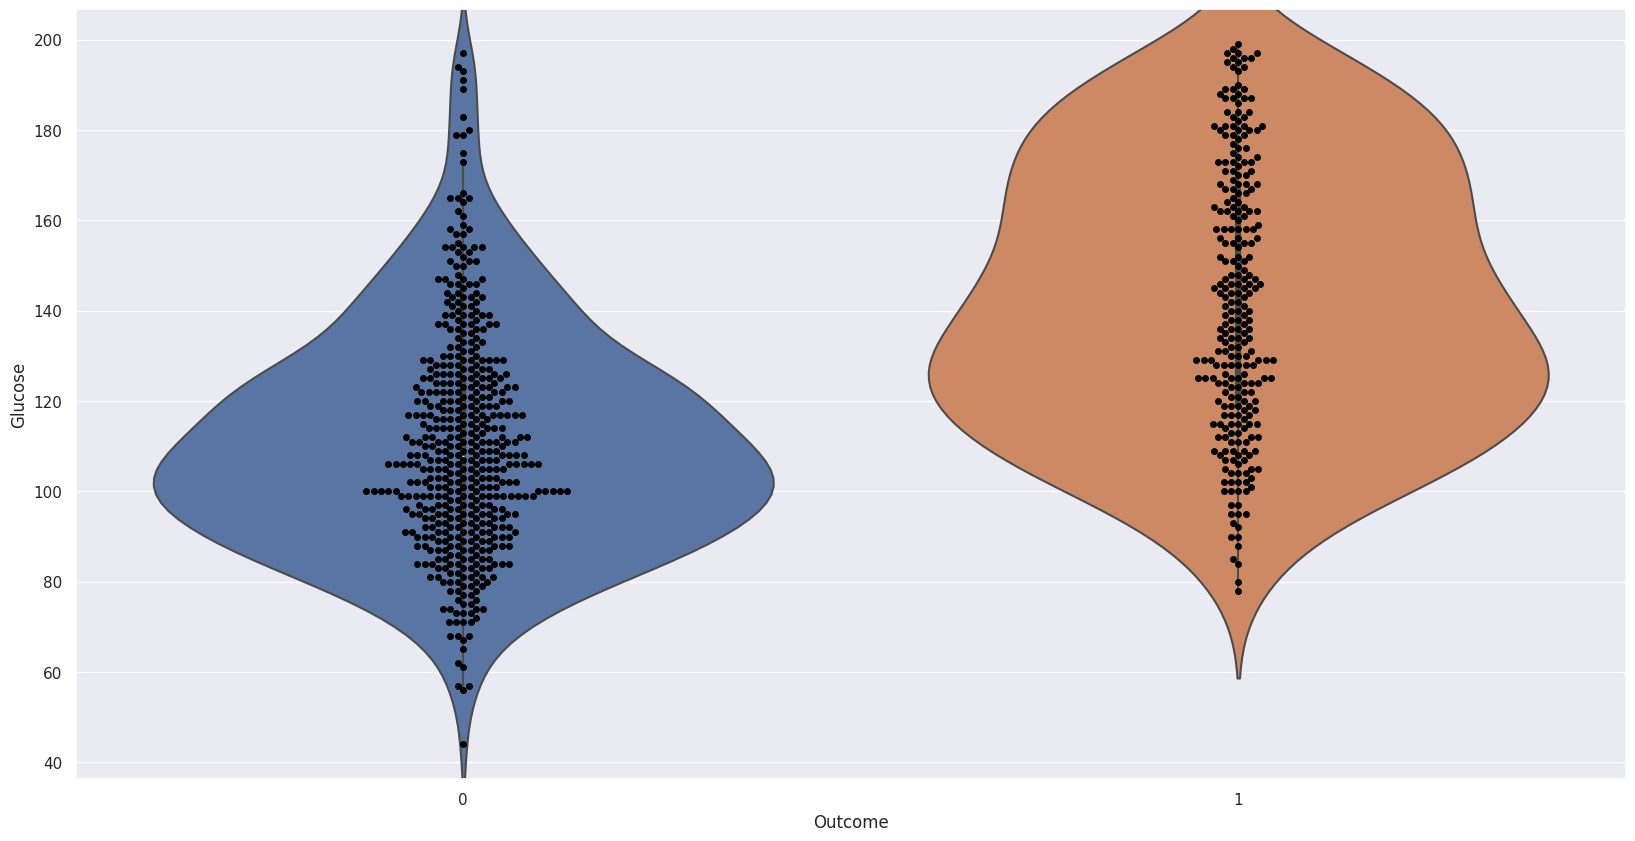

In [22]:
sns.violinplot(x="Outcome", y="Glucose", data=diabetes, scale="width")
sns.swarmplot(x='Outcome', y="Glucose", data=diabetes, color='black')
plt.show()

Plot gives us an intuition that the higher glucose level may result more often in the positive diabetes outcome. This can also be read from the scatterplot and the visualization of the glucose values distribution.

### Splitting the dataset

All machine learning algorithms that are mentioned in the paper are **first trained on the training set and then their performance is checked on the test set**. Because of this, **the target class distribution must be faithfully represented in both training and test set**. The same conclusion stays if need a validation set for tuning the algorithms. The author used a **70-30 dataset split**.

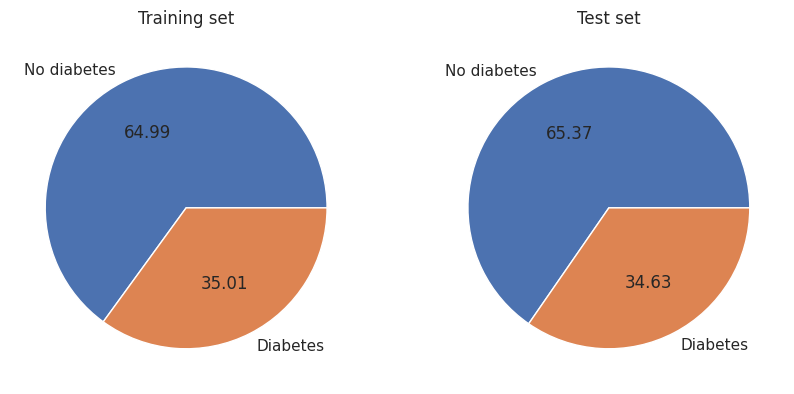

In [23]:
# split the dataset
random_state = 42
X = diabetes.loc[:, diabetes.columns != "Outcome"]
y = diabetes.loc[:, "Outcome"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state)

# Calculate the number of positive and negative examples in train and test dataset
_, counts_tr = np.unique(y_train, return_counts=True)
_, counts_test = np.unique(y_test, return_counts=True)

# define the axes and plot distributions
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
fig.set_size_inches(10, 8)
ax[0].pie(counts_tr, labels=["No diabetes", "Diabetes"], autopct='%.2f')
ax[0].set_title("Training set")
ax[1].pie(counts_test, labels=["No diabetes", "Diabetes"], autopct='%.2f')
ax[1].set_title("Test set")
plt.show()

The relative frequency of positive and negative examples is the same. Let's proceed to some machine learning classification!

## **2. Results replication**

As we already mentioned, the purpose of this study is to predict **diabetes mellitus**. However, there is also an inner goal hidden beneath making models **interpretable**. Such models are very important because they are clear and understandable to end-users regarding how they judge **which features are important and how the choice of features affects the model's prediction results**. This is closely related to the *Explainable AI* concept in which decisions made by ML models can be understood by their users. Interpretability, however, additionally refers to **the ability to observe cause and effect within such a model**. It is important to say that **interpretable models may not always be explainable** to an extent where the human mind fully comprehends the steps taking place to arrive at a decision made by an ML model. Because of this, the author decided to use three models: **decision trees, random forest and naive Bayes classifier**. Before jumping into classification, we will first try to find important feature by playing a bit with feature selection. For this, we will use **k-means, PCA and importance ranking.**

### Principal component analysis

**The PCA algorithm is a dimensionality-reduction technique** that is used to transform a large set of variables into a smaller one by trying to preserve as much information as possible. The first step necessary is to **standardize the data** because the method is quite sensitive regarding the variances of the initial variables. Next, **the covariance matrix is computed so that eigenvalues and eigenvectors** can be easily calculated. Now the new vectors, called **principal components**, can be constructed in such a way that the first component contains the maximum possible information and it points in the direction of the data that explains the maximum possible amount of variance. Each subsequent component is orthogonal to the previous one.

Explained variance: [1.12747918e+04 8.27831403e+02 1.69201140e+02 1.08691885e+02
 8.21210498e+01 2.48294439e+01 7.75561370e+00 1.03408339e-01]
Explained variance ratio: [9.02320759e-01 6.62512861e-02 1.35411547e-02 8.69860353e-03
 6.57214156e-03 1.98709857e-03 6.20681192e-04 8.27576177e-06]
Cumulative sum explained variance: [0.90232076 0.96857204 0.9821132  0.9908118  0.99738394 0.99937104
 0.99999172 1.        ]


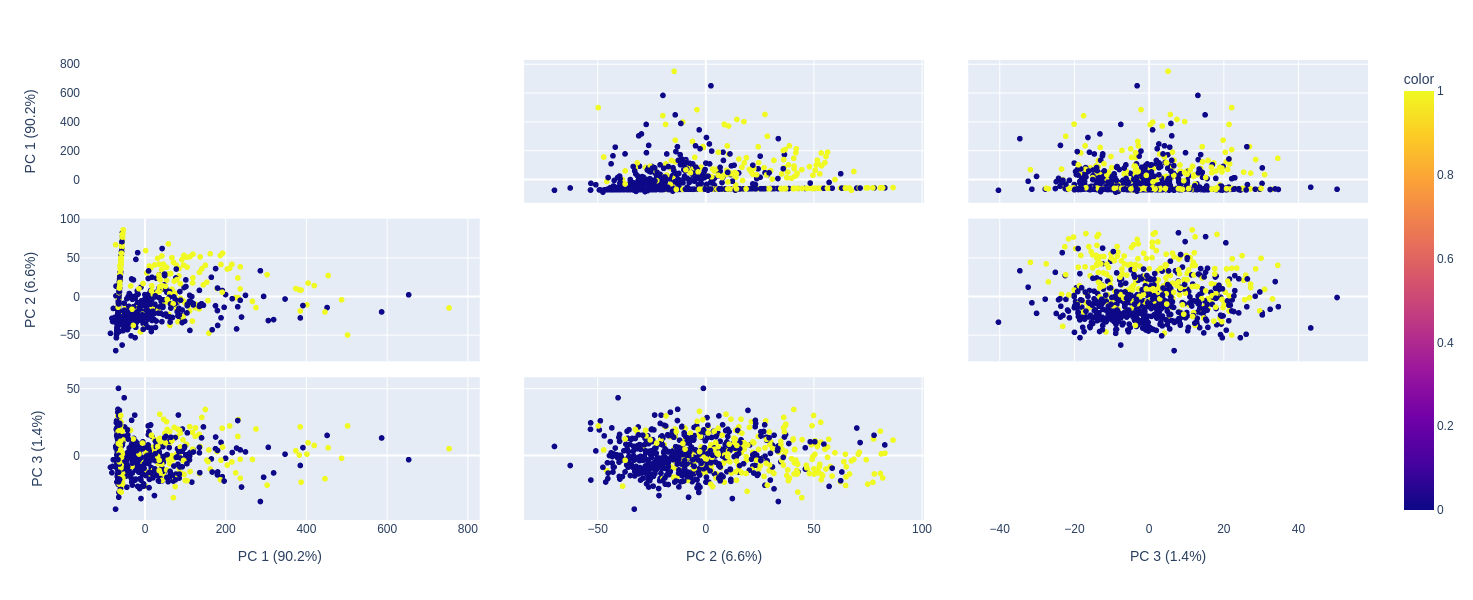

In [30]:
# Try to see what is the percentage of explained variance
explained_variances = []
pca = PCA(n_components=8)
components = pca.fit_transform(X)
explained_variance = pca.explained_variance_
explained_variance_ratios = pca.explained_variance_ratio_
explained_variance_ratios_cumsum = pca.explained_variance_ratio_.cumsum()
print(f"Explained variance: {explained_variance}")
print(f"Explained variance ratio: {explained_variance_ratios}")
print(f"Cumulative sum explained variance: {explained_variance_ratios_cumsum}")
labels = {
    str(i): f"PC {i+1} ({var:.1f}%)"
    for i, var in enumerate(pca.explained_variance_ratio_ * 100)
}

fig = px.scatter_matrix(
    components,
    labels=labels,
    dimensions=range(3),
    color=diabetes["Outcome"],
    width=600,
    height=600
)
fig.update_traces(diagonal_visible=False)
fig.show()
    

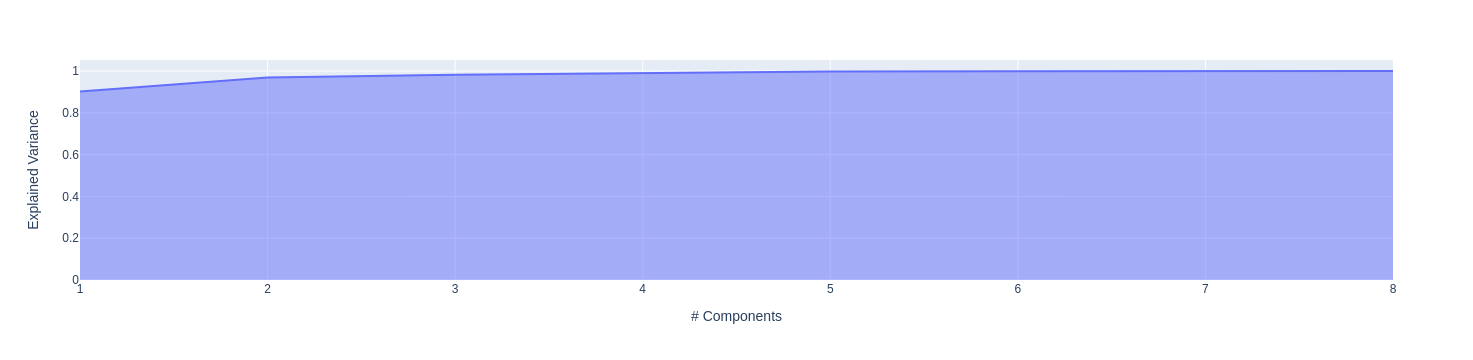

In [25]:
px.area(
    x=range(1, explained_variance_ratios_cumsum.shape[0] + 1),
    y=explained_variance_ratios_cumsum,
    labels={"x": "# Components", "y": "Explained Variance"}
)

We can see that the first two components explain 96.86% of the variance so we will continue to build on top of that.

### T-SNE

T-SNE is a visualization method that transforms high-dimensional data into low-dimensional (usually 2D) space. It works by calculating similarity measures between data points in a high-dimensional and low-dimensional space and then converts them to joint probabilities to minimize the Kullback-Leibler divergence between low and high-dimensional embedding.

Text(0, 0.5, 'y')

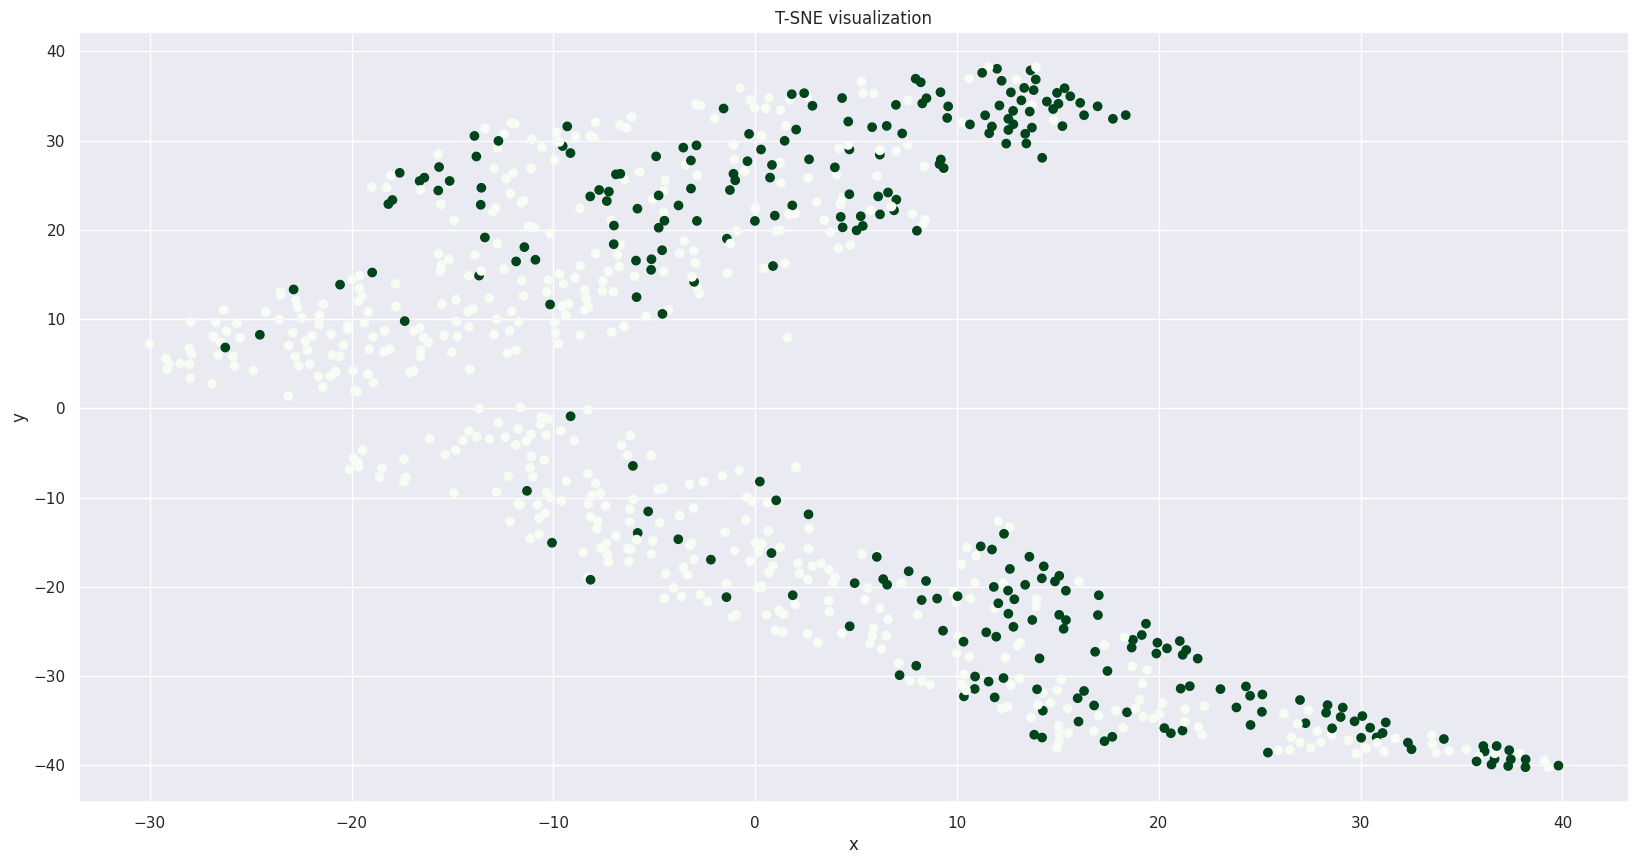

In [26]:
X_embedded = TSNE(n_components=2).fit_transform(X)
_, ax = plt.subplots(figsize=(20, 10))
ax.scatter(X_embedded[:, 0], X_embedded[:, 1], c=y, cmap=plt.cm.Greens)
ax.set_title("T-SNE visualization")
ax.set_xlabel("x")
ax.set_ylabel("y")

### K-means clustering

The **k-means clustering algorithm** is one of the simplest and most often used **unsupervised machine learning algorithms**. Its goal is to group similar data points together and to try to discover similar underlying patterns. It finishes when underlying **centroids have been stabilized or the predetermined number of iterations** has been achieved. The classical algorithm that is used is `Lloyd's` or `Elkan's`. The latter is more **memory intensive** but can be more time efficient on some larger datasets with well defined clusters. We will run the algorithm on the obtained PCA components.

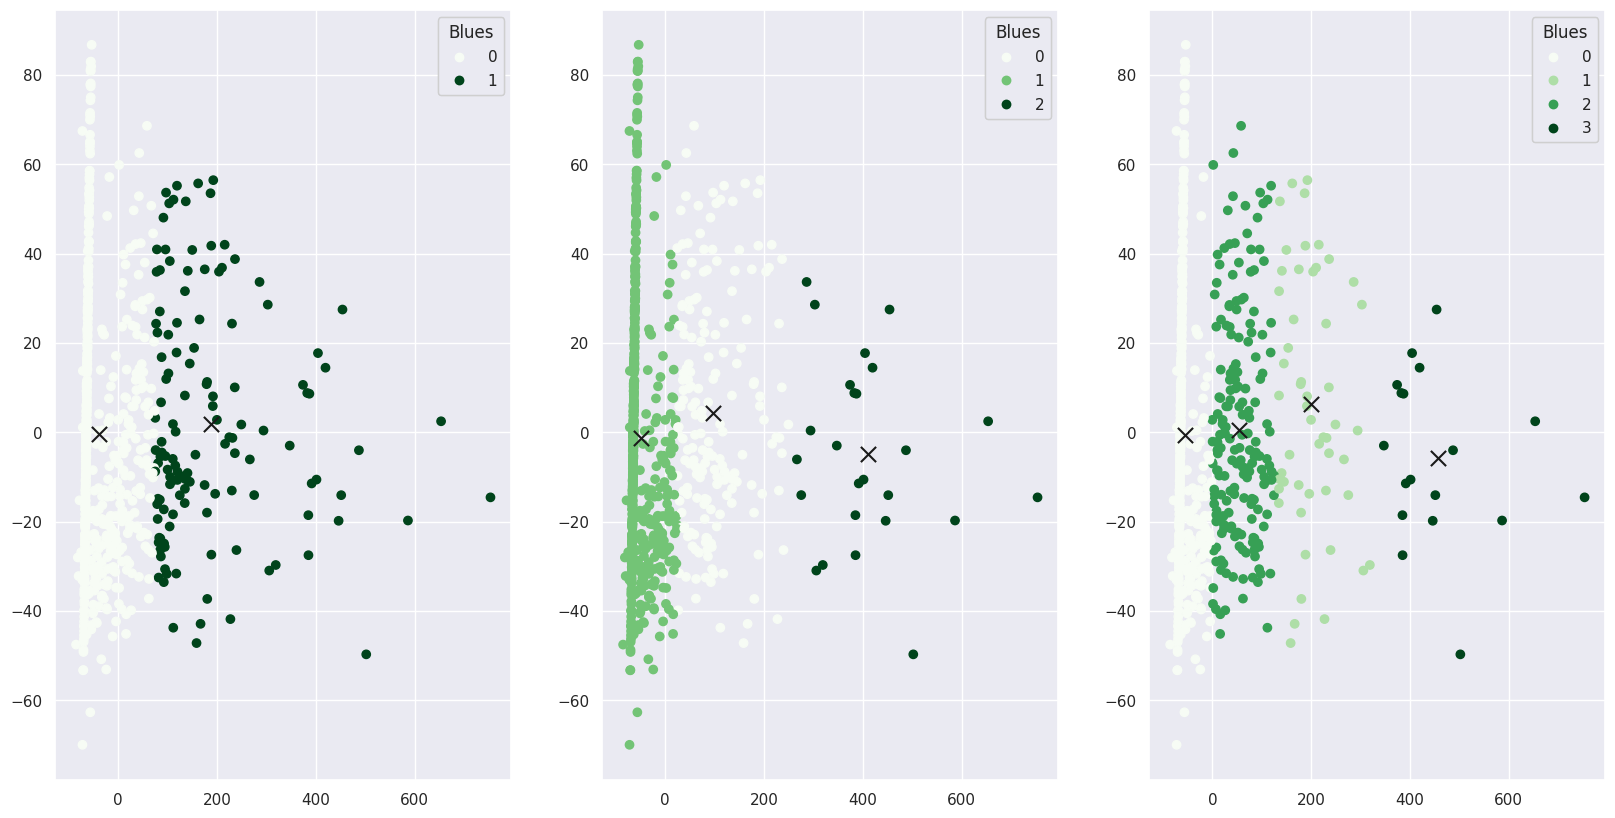

In [27]:
fix, ax = plt.subplots(1, 3, figsize=(20, 10))

for k in range(2, 5):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(components)
    labels = kmeans.predict(components)
    centroids = kmeans.cluster_centers_
    scatter = ax[k-2].scatter(components[:, 0], components[:, 1], c=labels, cmap=plt.cm.Greens)
    legend = ax[k-2].legend(*scatter.legend_elements(), loc="best", title="Blues")
    scatter = ax[k-2].scatter(centroids[:,0] , centroids[:,1] , s = 120, color = 'k', marker='x', label='centroid')
    ax[k-2].add_artist(legend)


From the algorithm's result, it is hard to conclude what fits best but somehow the plot with three clusters makes most sense.

### Feature selection

The **feature selection** process is very important because it allows us to understand what is important and what is irrelevant. Also, it can significantly **reduce computational time and overfitting**. There are many possible approaches one can take. The **wrapper method makes use of classifiers** and their output as a goal to be optimized, so instead of obtaining **the most important features** in general (which is a very general term and highly specific to the approach used), we calculate **the most important features specific to some classifier**. There is also a **3rd *embedded* approach that typically couples the predictor search algorithm with the parameter estimation through the single objective function**.

Most important features: ['Glucose' 'BMI' 'Age' 'DiabetesPedigreeFunction' 'BloodPressure']
Feature importances: [0.27174395 0.16282581 0.1441079  0.11130999 0.08475389]


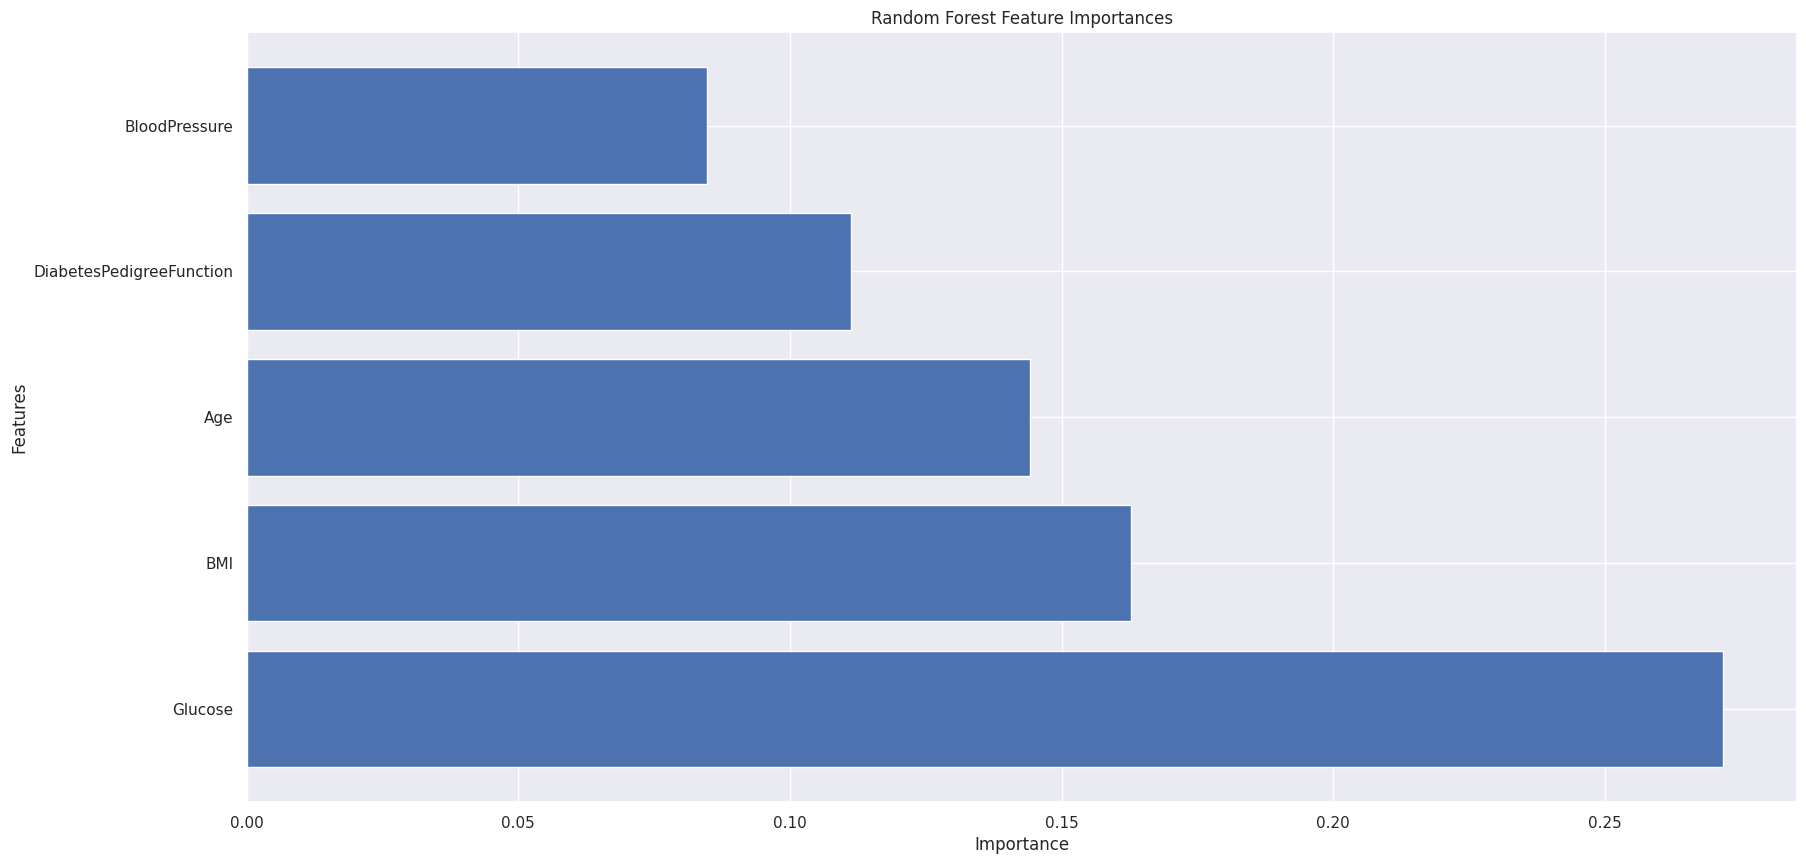

In [32]:
def get_important_features(num_features: int):
    rf_model = RandomForestClassifier(n_estimators=100)
    rf_model.fit(X_train, y_train)
    fs_indices_rfi = np.argsort(rf_model.feature_importances_)[::-1][0:num_features]
    best_features_rfi = X.columns[fs_indices_rfi].values
    print(f"Most important features: {best_features_rfi}")
    feature_importances_rfi = rf_model.feature_importances_[fs_indices_rfi]
    print(f"Feature importances: {feature_importances_rfi}")
    return best_features_rfi, feature_importances_rfi

def plot_imp(best_features, scores, method_name):   
    plt.barh(best_features, scores)
    plt.title(method_name + ' Feature Importances')
    plt.xlabel("Importance")
    plt.ylabel("Features")
    plt.show()


best_features_rfi_five, feature_importances_rfi_five = get_important_features(5)
best_features_rfi_three, feature_importances_rfi_three = best_features_rfi_five[0:3], feature_importances_rfi_five[0:3]
plot_imp(best_features_rfi_five, feature_importances_rfi_five, 'Random Forest')

# Obtain dataset by taking five and three most important features
X_train_five, X_test_five = X_train.loc[:, best_features_rfi_five], X_test.loc[:, best_features_rfi_five]
X_train_three, X_test_three = X_train.loc[:, best_features_rfi_three], X_test.loc[:, best_features_rfi_three]

We can see that this method gives a little bit different results than what author wrote in his work. In the paper, *Glucose, BMI, Age, Insuling and Skin* were five most importance features while we got *Glucose, BMI, Age, DiabetesPedigreeFunction and BloodPressure* as the most important ones. However, in both results three most important features are the same so we will later create two experiments, one with five features and the second with three feautures. 

## Metrics
All classifiers must be objectively evaluated and for this, we will use 6 metrics authors used in the original paper. These are:
1. **Accuracy** refers to the percentage of all samples that have been correctly predicted.
\begin{equation}
Accuracy = \frac{TP + TN} {TP+TN+FP+FN}
\end{equation}
2. **Precision** refers to the percentage of all samples that have been correctly predicted as true among all those which were predicted as true.
\begin{equation}
Precision = \frac{TP}{TP+FP}
\end{equation}
3. **Recall** refers to the percentage of all samples that have been correctly predicted as true among all those which were predicted true as well as those predicted false but were true.
\begin{equation}
Recall = \frac{TP}{TP+FN}
\end{equation}
4. **Specificity** refers to the percentage of all samples that have been correctly predicted as false among all those which were false even if predicted incorrectly.
\begin{equation}
Specificity = \frac{TN}{TN+FP}
\end{equation}
5. **F1 score** is an indicator of a binary classification model's accuracy calculated as a weighted average of precision and recall
\begin{equation}
F1 = \frac {2*Precision*Recall}{Precision + Recall}
\end{equation}
6. **AUC score** is an aggregate measure over all classification thresholds. It can be interpreted as a probability that a random positive example is ranked higher than a random negative example.

In [33]:
# Define some utils
def get_metrics(orig: np.array, pred: np.array, pred_prob: np.array) -> Dict[str, float]:
    acc = accuracy_score(orig, pred)
    prec = precision_score(orig, pred)
    rec = recall_score(orig, pred)
    f1 = f1_score(orig, pred)
    roc_auc = roc_auc_score(orig, pred_prob)
    tn, fp, fn, tp = confusion_matrix(orig, pred).ravel()
    print(f"tn: {tn} fp: {fp} fn: {fn} tp: {tp}")
    spec = tn / (tn + fp)
    return {"acc": acc, "prec": prec, "rec": rec, "spec": spec, "f1": f1, "roc_auc": roc_auc}

## Decision trees

**Decision trees** are simple **supervised learning algorithms** that can be used to perform classification and regression. They offer several advantages over other often-used supervised algorithms:
- it requires very little data preparation -> **normalization is not required**
- it is efficient because the complexity of the inference procedure is **$O(log(n))$**, where n is the number of data points
- can handle numerical and categorical variables
- works also on **multi-output problem**
- it is a **white box model** -> totally explainable
**Complexity:**
- $O(n_{samples}^2)*O(log(n_{samples})*O(n_{features}))$ -> total cost over the entire tree
- at each node, we need to find the optimal feature, the one with **the largest information gain**

tn: 113 fp: 38 fn: 25 tp: 55
All features: {'acc': 0.7272727272727273, 'prec': 0.5913978494623656, 'rec': 0.6875, 'spec': 0.7483443708609272, 'f1': 0.6358381502890175, 'roc_auc': 0.7179221854304636}
tn: 111 fp: 40 fn: 28 tp: 52
Five features: {'acc': 0.7056277056277056, 'prec': 0.5652173913043478, 'rec': 0.65, 'spec': 0.7350993377483444, 'f1': 0.6046511627906976, 'roc_auc': 0.6925496688741721}
tn: 102 fp: 49 fn: 37 tp: 43
Three features: {'acc': 0.6277056277056277, 'prec': 0.4673913043478261, 'rec': 0.5375, 'spec': 0.6754966887417219, 'f1': 0.5, 'roc_auc': 0.6064983443708609}


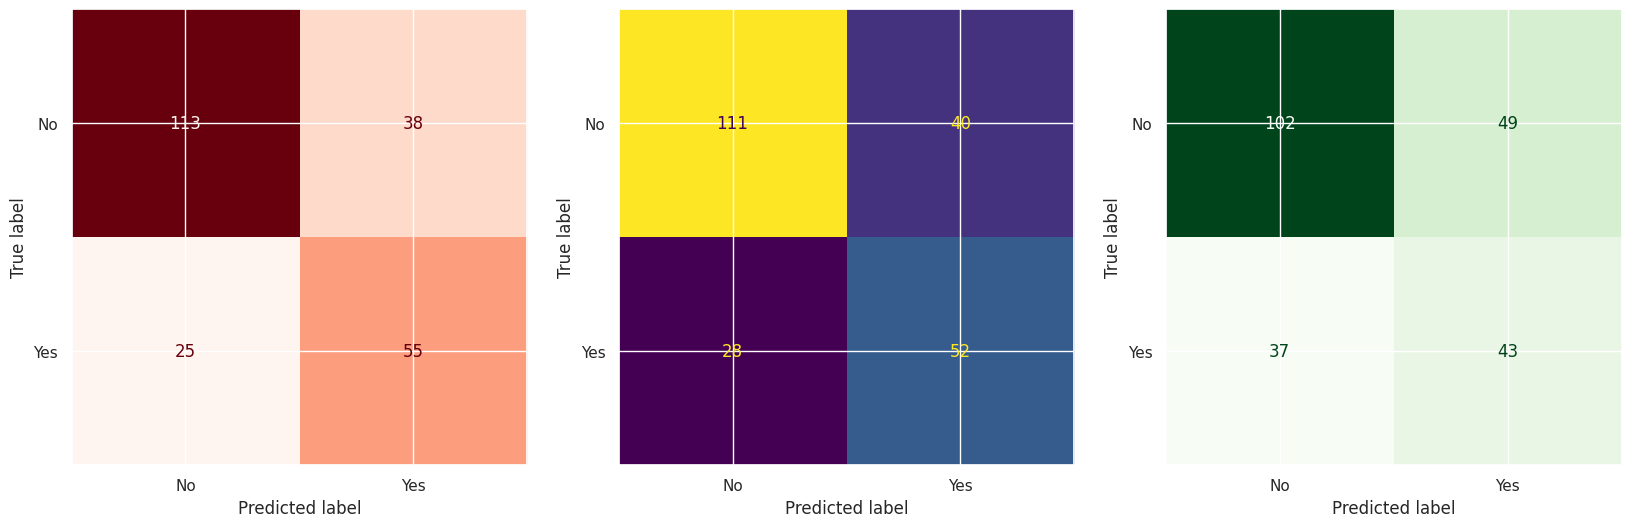

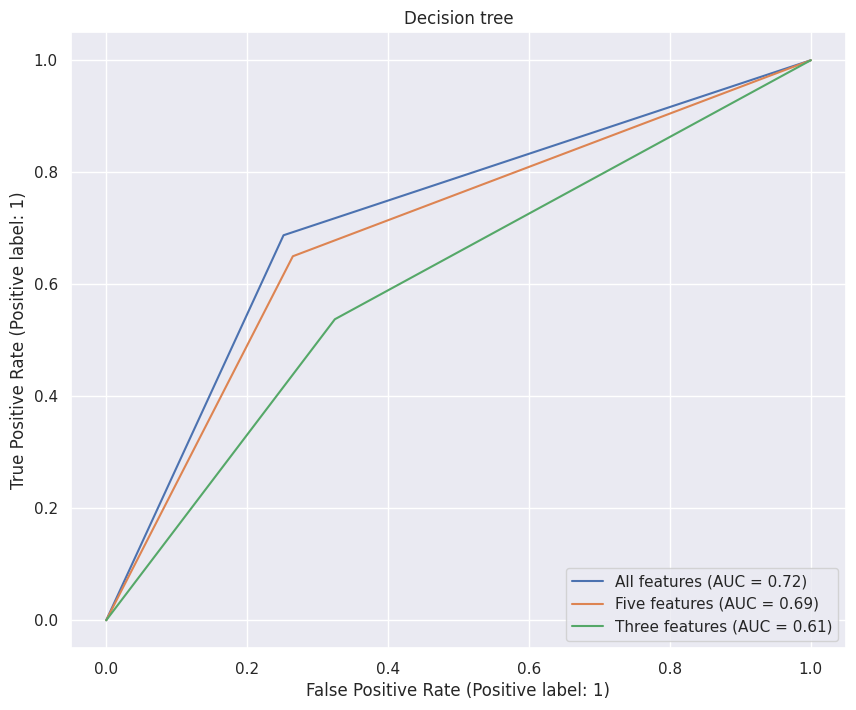

In [35]:
# Decision tree processing
fig_cm, ax_cm = plt.subplots(1, 3, figsize=(20, 10))
fig_roc, ax_roc = plt.subplots(figsize=(10, 8))
# Get predictions when using all features
d_all_dt = DecisionTreeClassifier()
d_all_dt.fit(X_train, y_train)
y_all_pred, y_all_pred_prob = d_all_dt.predict(X_test), d_all_dt.predict_proba(X_test)[:, 1]
all_res_dt = get_metrics(y_test, y_all_pred, y_all_pred_prob)
plot_confusion_matrix(d_all_dt, X_test, y_test, cmap=plt.cm.Reds, ax=ax_cm[0], colorbar=False, display_labels=["No", "Yes"])
plot_roc_curve(d_all_dt, X_test, y_test, ax=ax_roc, name="All features")
print(f"All features: {all_res_dt}")
# Get predictions when using five most important features
d_five_dt = DecisionTreeClassifier()
d_five_dt.fit(X_train_five, y_train)
y_five_pred, y_five_pred_prob = d_five_dt.predict(X_test_five), d_five_dt.predict_proba(X_test_five)[:, 1]
five_res_dt = get_metrics(y_test, y_five_pred, y_five_pred_prob)
plot_confusion_matrix(d_five_dt, X_test_five, y_test, ax=ax_cm[1], colorbar=False, display_labels=["No", "Yes"])
plot_roc_curve(d_five_dt, X_test_five, y_test, ax=ax_roc, name="Five features")
print(f"Five features: {five_res_dt}")
# Get predictions when using three most important features
d_three_dt = DecisionTreeClassifier()
d_three_dt.fit(X_train_three, y_train)
y_three_pred, y_three_pred_prob = d_three_dt.predict(X_test_three), d_three_dt.predict_proba(X_test_three)[:, 1]
three_res_dt = get_metrics(y_test, y_three_pred, y_three_pred_prob)
plot_confusion_matrix(d_three_dt, X_test_three, y_test, ax=ax_cm[2], colorbar=False, cmap=plt.cm.Greens, display_labels=["No", "Yes"])
plot_roc_curve(d_three_dt, X_test_three, y_test, ax=ax_roc, name="Three features")
ax_roc.set_title("Decision tree")
print(f"Three features: {three_res_dt}")

It can be seen that selecting most important features doesn't payoff in decision trees and that all features provide much better results, especially compared to taking only three features.

### Random forest

A **random forest classifier** is an ensemble method that consists of **a large number of decision trees**. Each decision tree makes a prediction and the assumption is that by using the principle **wisdom of crowds**, many **uncorrelated decision trees will operate better than an individual**. Here, the crucial term is uncorrelated because if decision trees are uncorrelated and all of them **aren't biased in one direction**, they will cover each other's error, **yielding, in the end, a lower error**. To conclude, random forest models perform very well because relatively many unrelated trees operate as a whole better than a single tree. Obtaining the most relevant features for **a random forest is computed based on a normalized total reduction** of the criterion brought by that feature. We will use **Gini importance** as a default option.

tn: 124 fp: 27 fn: 28 tp: 52
All features: {'acc': 0.7619047619047619, 'prec': 0.6582278481012658, 'rec': 0.65, 'spec': 0.8211920529801324, 'f1': 0.6540880503144655, 'roc_auc': 0.8048427152317881}
tn: 116 fp: 35 fn: 27 tp: 53
Five features: {'acc': 0.7316017316017316, 'prec': 0.6022727272727273, 'rec': 0.6625, 'spec': 0.7682119205298014, 'f1': 0.6309523809523809, 'roc_auc': 0.7959850993377484}
tn: 116 fp: 35 fn: 28 tp: 52
Three features: {'acc': 0.7272727272727273, 'prec': 0.5977011494252874, 'rec': 0.65, 'spec': 0.7682119205298014, 'f1': 0.6227544910179641, 'roc_auc': 0.7825331125827815}


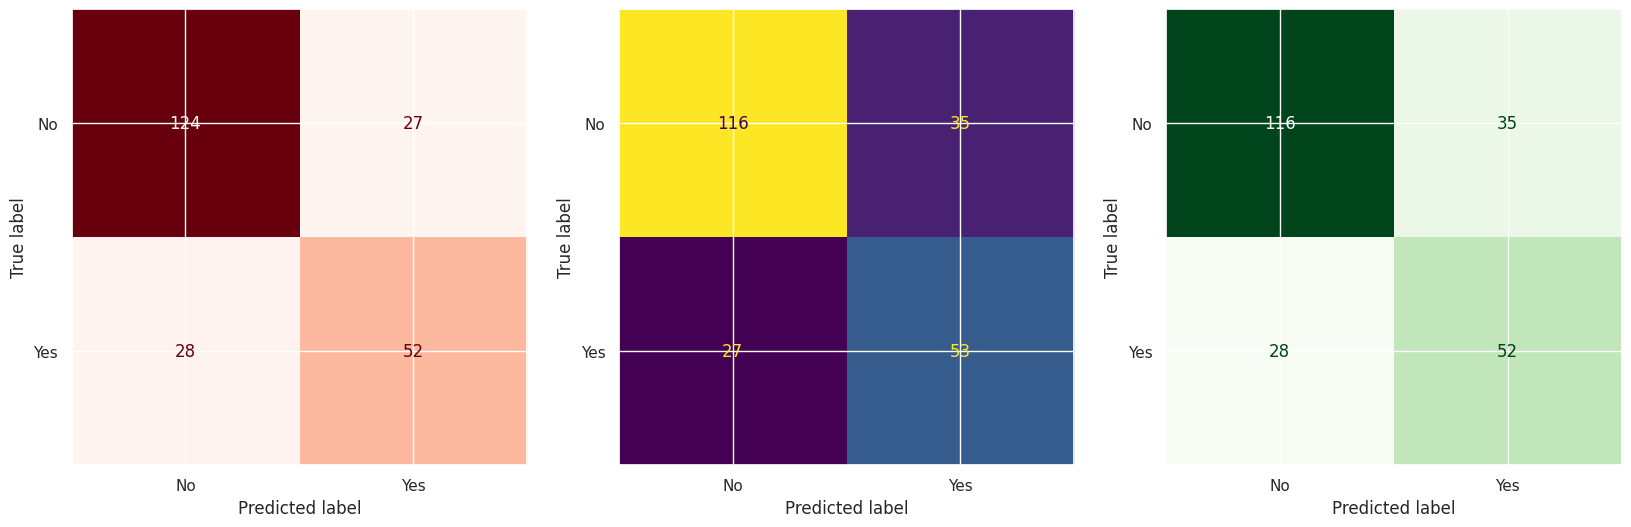

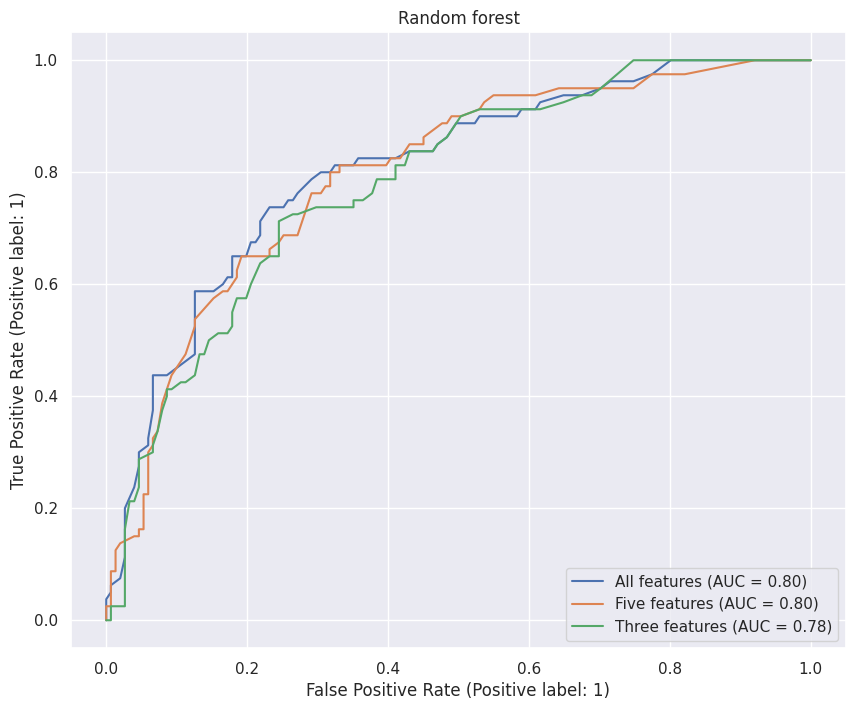

In [37]:
fig_cm, ax_cm = plt.subplots(1, 3, figsize=(20, 10))
fig_roc, ax_roc = plt.subplots(figsize=(10, 8))
# Get predictions when using all features
d_all_rf = RandomForestClassifier(n_estimators=100)
d_all_rf.fit(X_train, y_train)
y_all_pred, y_all_pred_prob = d_all_rf.predict(X_test), d_all_rf.predict_proba(X_test)[:, 1]
all_res_rf = get_metrics(y_test, y_all_pred, y_all_pred_prob)
plot_confusion_matrix(d_all_rf, X_test, y_test, cmap=plt.cm.Reds, ax=ax_cm[0], colorbar=False, display_labels=["No", "Yes"])
plot_roc_curve(d_all_rf, X_test, y_test, ax=ax_roc, name="All features")
print(f"All features: {all_res_rf}")
# Get predictions when using five most important features
d_five_rf = RandomForestClassifier(n_estimators=100)
d_five_rf.fit(X_train_five, y_train)
y_five_pred, y_five_pred_prob = d_five_rf.predict(X_test_five), d_five_rf.predict_proba(X_test_five)[:, 1]
five_res_rf = get_metrics(y_test, y_five_pred, y_five_pred_prob)
plot_confusion_matrix(d_five_rf, X_test_five, y_test, ax=ax_cm[1], colorbar=False, display_labels=["No", "Yes"])
plot_roc_curve(d_five_rf, X_test_five, y_test, ax=ax_roc, name="Five features")
print(f"Five features: {five_res_rf}")
# Get predictions when using three most important features
d_three_rf = RandomForestClassifier(n_estimators=100)
d_three_rf.fit(X_train_three, y_train)
y_three_pred, y_three_pred_prob = d_three_rf.predict(X_test_three), d_three_rf.predict_proba(X_test_three)[:, 1]
three_res_rf = get_metrics(y_test, y_three_pred, y_three_pred_prob)
plot_confusion_matrix(d_three_rf, X_test_three, y_test, ax=ax_cm[2], colorbar=False, cmap=plt.cm.Greens, display_labels=["No", "Yes"])
plot_roc_curve(d_three_rf, X_test_three, y_test, ax=ax_roc, name="Three features")
ax_roc.set_title("Random forest")
print(f"Three features: {three_res_rf}")

Compared to decision trees, with random forests the situation is different. Taking the three and five most important features provides results as good as when taking all so in this case, the feature selection process pays of.

## Naive Bayes classifier

**Naive Bayes methods** are **a set of statistical algorithms** that use **Bayes theorem** to classify data into predetermined categories using **conditional probabilities**. <br/>
\begin{equation}
p(y|x) = \frac{p(x|y)*p(y)}{p(x)}
\end{equation}
They make use of **a naive conditional independence assumption** such that:
\begin{equation}
P(x_i|y, x_1, x_2...x_n) = \prod_{i}p(x_i|y)
\end{equation}
By knowing this, we can make a final classification using the rule:
\begin{equation}
y = argmax_{y} p(y) \prod_{i}p(x_i|y)
\end{equation}
Such methods mostly differ based on a **probability distribution assumption they put on $p(x_i|y)$**. 
Naive Bayes is also regarded as **a descriptive algorithm** because it makes **predictions based on a probabilities**. This probabilities are often **bad estimations of real probabilites** but overall, algorithm performs surprisingly well in a variety of cases, especially in **document classification and spam detection**. **Its great strength is the ability to work very well without requiring a large number of samples.**

tn: 118 fp: 33 fn: 29 tp: 51
All features: {'acc': 0.7316017316017316, 'prec': 0.6071428571428571, 'rec': 0.6375, 'spec': 0.7814569536423841, 'f1': 0.6219512195121951, 'roc_auc': 0.7962748344370861}
tn: 122 fp: 29 fn: 32 tp: 48
Five features: {'acc': 0.7359307359307359, 'prec': 0.6233766233766234, 'rec': 0.6, 'spec': 0.8079470198675497, 'f1': 0.6114649681528662, 'roc_auc': 0.7976821192052981}
tn: 121 fp: 30 fn: 33 tp: 47
Three features: {'acc': 0.7272727272727273, 'prec': 0.6103896103896104, 'rec': 0.5875, 'spec': 0.8013245033112583, 'f1': 0.5987261146496815, 'roc_auc': 0.7761589403973509}


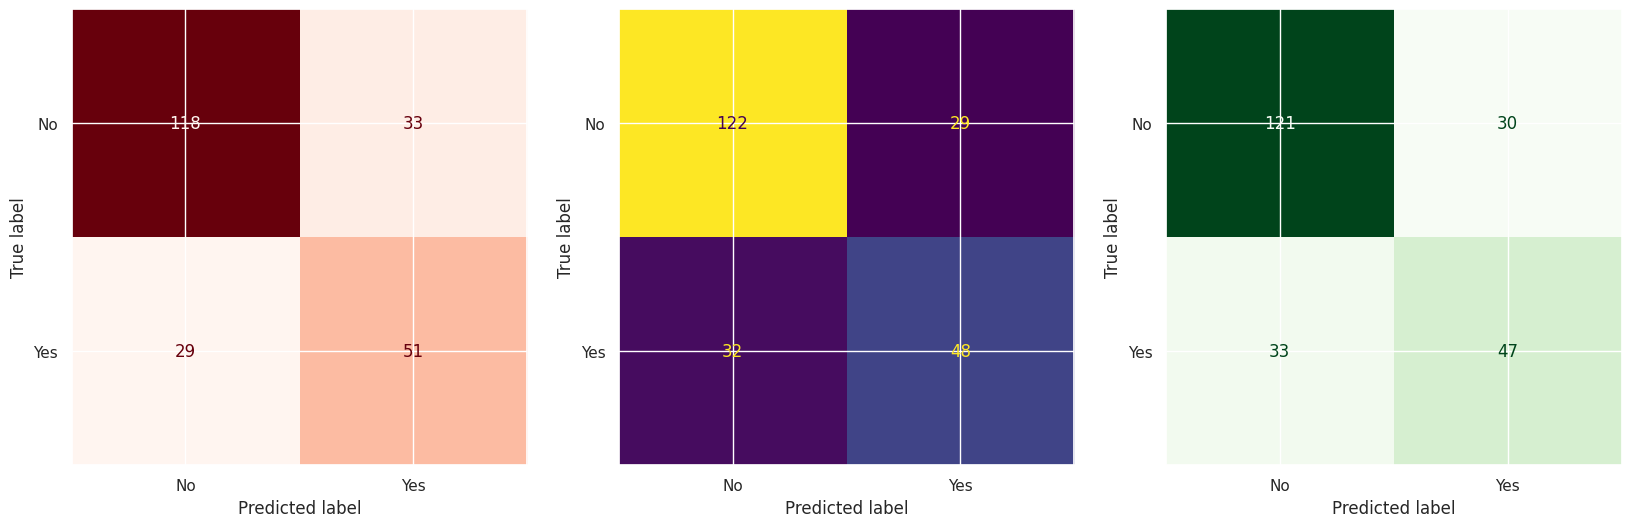

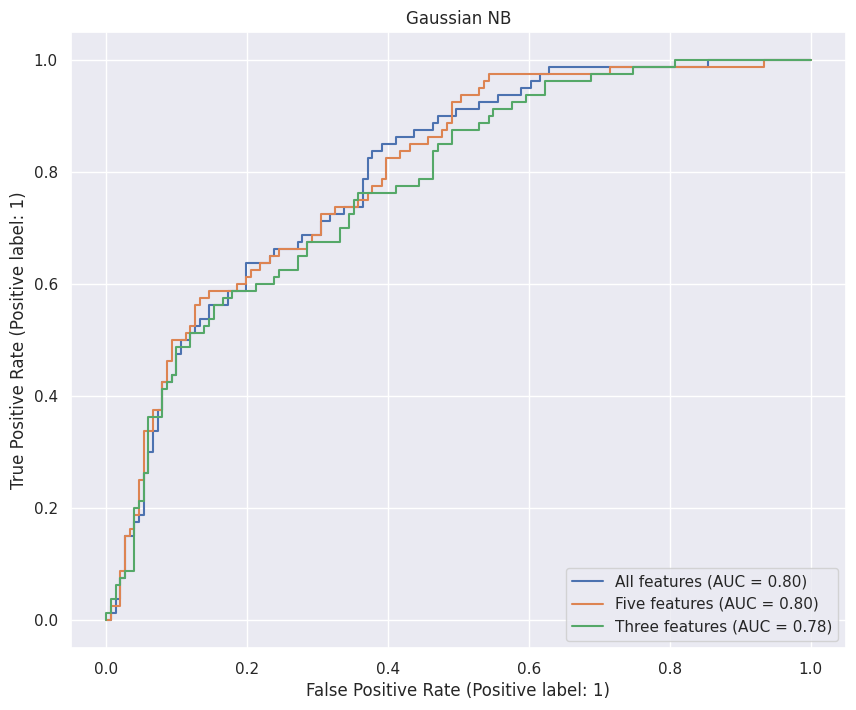

In [38]:
fig_cm, ax_cm = plt.subplots(1, 3, figsize=(20, 10))
fig_roc, ax_roc = plt.subplots(figsize=(10, 8))
# Get predictions when using all features
d_all_nb = GaussianNB()
d_all_nb.fit(X_train, y_train)
y_all_pred, y_all_pred_prob = d_all_nb.predict(X_test), d_all_nb.predict_proba(X_test)[:, 1]
all_res_nb = get_metrics(y_test, y_all_pred, y_all_pred_prob)
plot_confusion_matrix(d_all_nb, X_test, y_test, cmap=plt.cm.Reds, ax=ax_cm[0], colorbar=False, display_labels=["No", "Yes"])
plot_roc_curve(d_all_nb, X_test, y_test, ax=ax_roc, name="All features")
print(f"All features: {all_res_nb}")
# Get predictions when using five most important features
d_five_nb = GaussianNB()
d_five_nb.fit(X_train_five, y_train)
y_five_pred, y_five_pred_prob = d_five_nb.predict(X_test_five), d_five_nb.predict_proba(X_test_five)[:, 1]
five_res_nb = get_metrics(y_test, y_five_pred, y_five_pred_prob)
plot_confusion_matrix(d_five_nb, X_test_five, y_test, ax=ax_cm[1], colorbar=False, display_labels=["No", "Yes"])
plot_roc_curve(d_five_nb, X_test_five, y_test, ax=ax_roc, name="Five features")
print(f"Five features: {five_res_nb}")
# Get predictions when using three most important features
d_three_nb = GaussianNB()
d_three_nb.fit(X_train_three, y_train)
y_three_pred, y_three_pred_prob = d_three_nb.predict(X_test_three), d_three_nb.predict_proba(X_test_three)[:, 1]
three_res_nb = get_metrics(y_test, y_three_pred, y_three_pred_prob)
plot_confusion_matrix(d_three_nb, X_test_three, y_test, ax=ax_cm[2], colorbar=False, cmap=plt.cm.Greens, display_labels=["No", "Yes"])
plot_roc_curve(d_three_nb, X_test_three, y_test, ax=ax_roc, name="Three features")
ax_roc.set_title("Gaussian NB")
print(f"Three features: {three_res_nb}")

The situation with the Naive Bayes classifier is similar to random forest algorithms. The feature selection process pays off and the results are quite similar.

### Comparing methods

In this section we will compare algorithms head to head and try to conclude what works best for our use case.

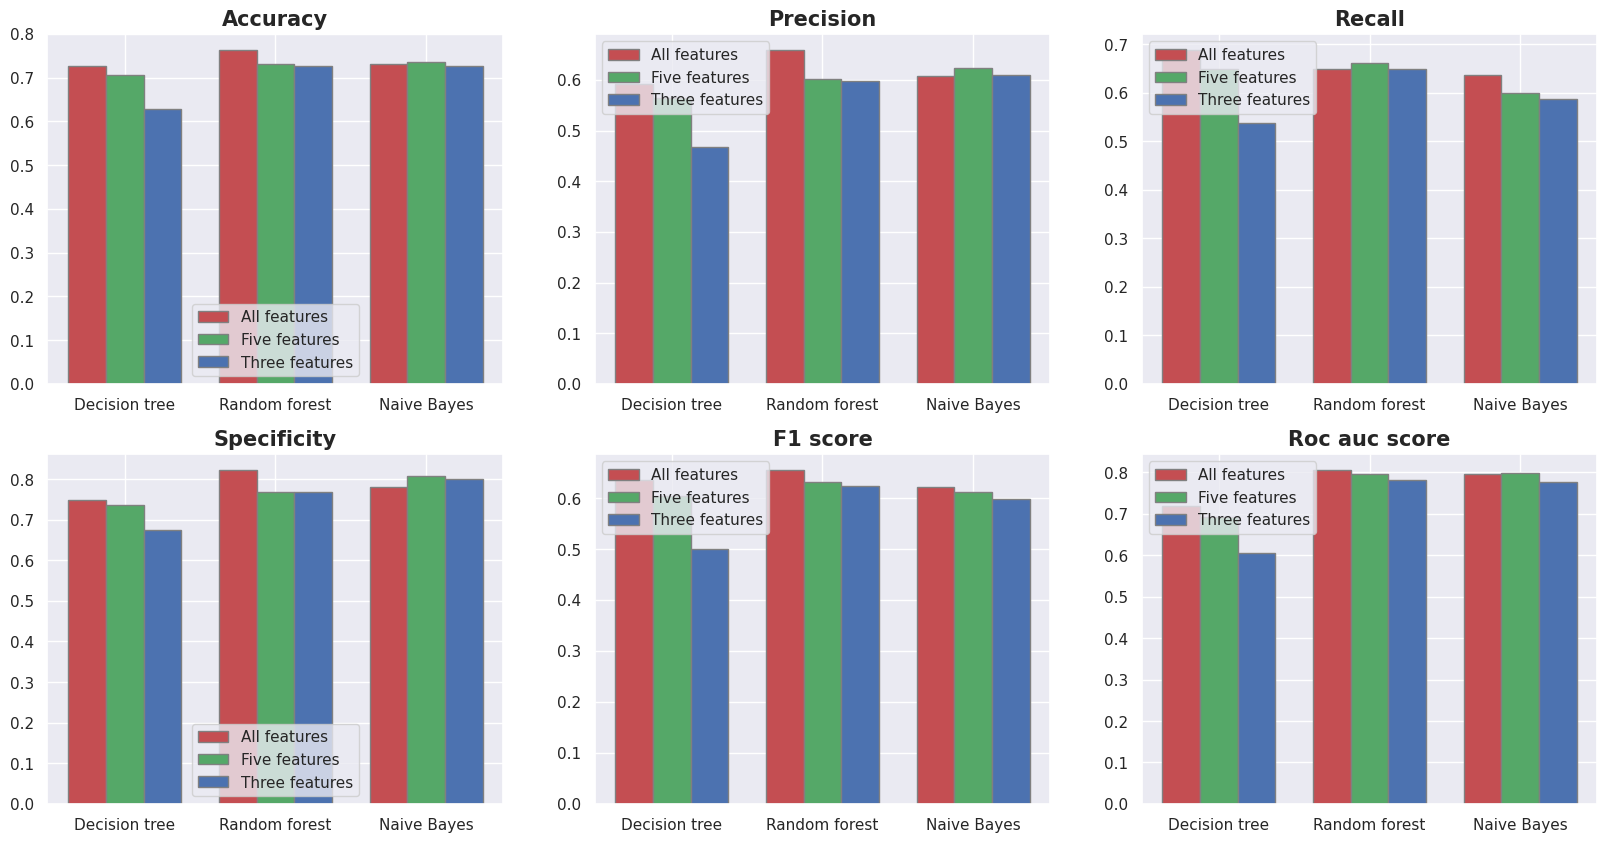

In [48]:
methods = ["Decision tree", "Random forest", "Naive Bayes",]
# Accuracy
all_accs = [all_res_dt["acc"], all_res_rf["acc"], all_res_nb["acc"]]
five_accs = [five_res_dt["acc"], five_res_rf["acc"], five_res_nb["acc"]]
three_accs = [three_res_dt["acc"], three_res_rf["acc"], three_res_nb["acc"]]
# Precision
all_prec = [all_res_dt["prec"], all_res_rf["prec"], all_res_nb["prec"]]
five_prec = [five_res_dt["prec"], five_res_rf["prec"], five_res_nb["prec"]]
three_prec = [three_res_dt["prec"], three_res_rf["prec"], three_res_nb["prec"]]
# Recall
all_rec = [all_res_dt["rec"], all_res_rf["rec"], all_res_nb["rec"]]
five_rec = [five_res_dt["rec"], five_res_rf["rec"], five_res_nb["rec"]]
three_rec = [three_res_dt["rec"], three_res_rf["rec"], three_res_nb["rec"]]
# Specificity
all_spec = [all_res_dt["spec"], all_res_rf["spec"], all_res_nb["spec"]]
five_spec = [five_res_dt["spec"], five_res_rf["spec"], five_res_nb["spec"]]
three_spec = [three_res_dt["spec"], three_res_rf["spec"], three_res_nb["spec"]]
# F1 score
all_f1 = [all_res_dt["f1"], all_res_rf["f1"], all_res_nb["f1"]]
five_f1 = [five_res_dt["f1"], five_res_rf["f1"], five_res_nb["f1"]]
three_f1 = [three_res_dt["f1"], three_res_rf["f1"], three_res_nb["f1"]]
# Roc auc score
all_roc = [all_res_dt["roc_auc"], all_res_rf["roc_auc"], all_res_nb["roc_auc"]]
five_roc = [five_res_dt["roc_auc"], five_res_rf["roc_auc"], five_res_nb["roc_auc"]]
three_roc = [three_res_dt["roc_auc"], three_res_rf["roc_auc"], three_res_nb["roc_auc"]]

# Get plot properties
fig, ax = plt.subplots(2, 3, figsize=(20, 10))
barWidth = 0.25
br1 = np.arange(len(methods))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
def bar_plot(ax, dt, rf, nb, title):
    ax.bar(br1, dt, color ='r', width = barWidth, edgecolor ='grey', label ='All features')
    ax.bar(br2, rf, color ='g', width = barWidth, edgecolor ='grey', label ='Five features')
    ax.bar(br3, nb, color ='b', width = barWidth, edgecolor ='grey', label ='Three features')
    ax.set_xticks([r + barWidth for r in range(len(methods))], methods)
    ax.set_title(title, fontweight ='bold', fontsize = 15)
    ax.legend()
# Plot    
bar_plot(ax[0, 0], all_accs, five_accs, three_accs, "Accuracy")
bar_plot(ax[0, 1], all_prec, five_prec, three_prec, "Precision")
bar_plot(ax[0, 2], all_rec, five_rec, three_rec, "Recall")
bar_plot(ax[1, 0], all_spec, five_spec, three_spec, "Specificity")
bar_plot(ax[1, 1], all_f1, five_f1, three_f1, "F1 score")
bar_plot(ax[1, 2], all_roc, five_roc, three_roc, "Roc auc score")

Text(0.5, 1.0, 'Three features')

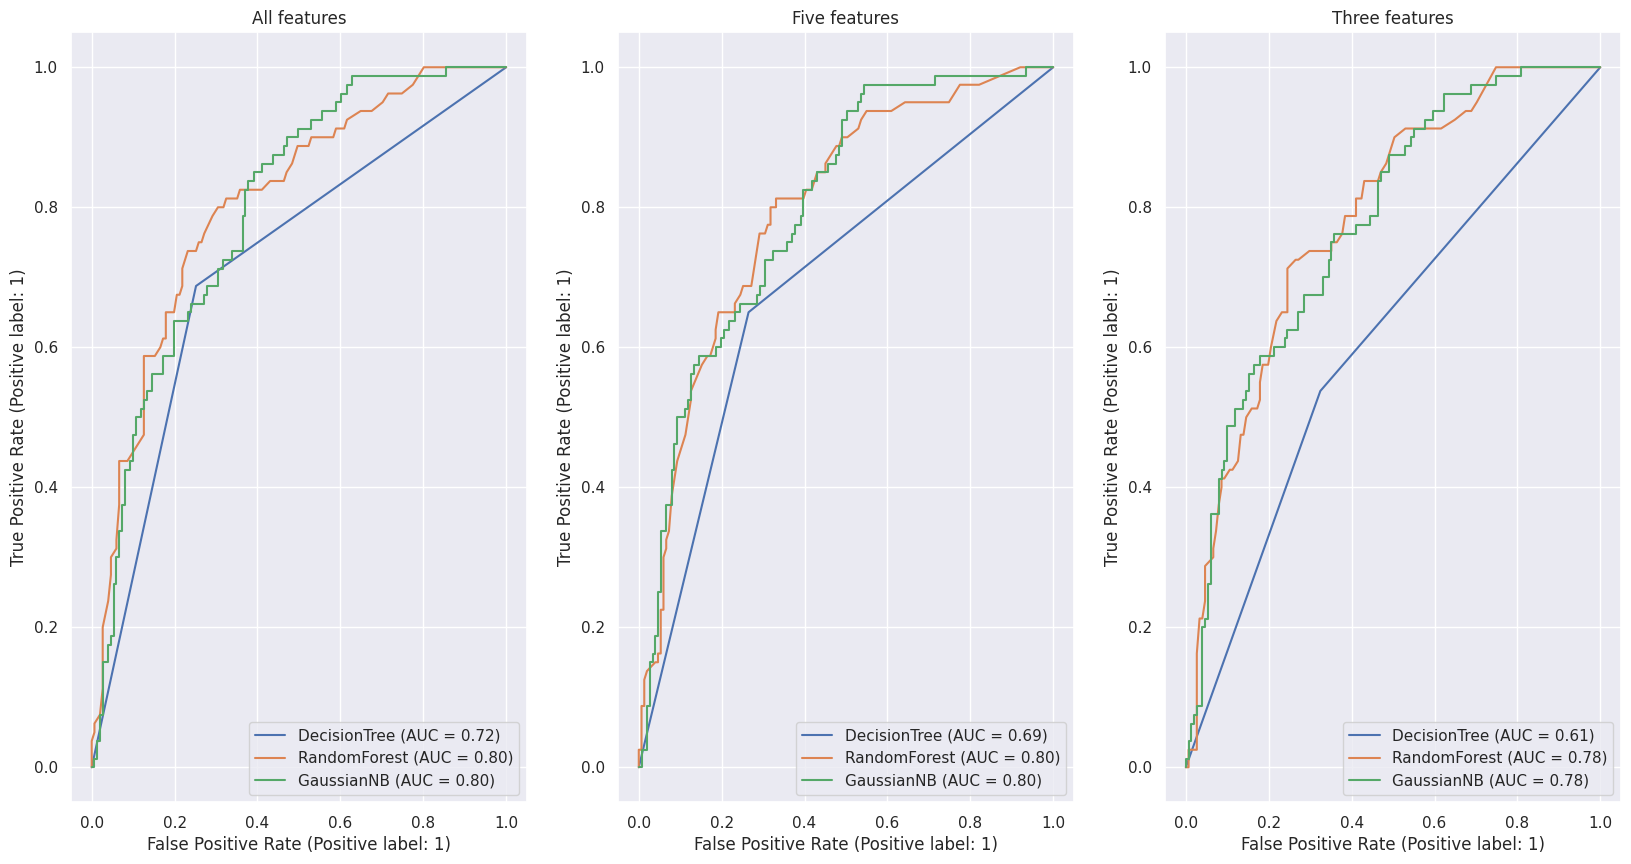

In [40]:
# Compare classifiers' roc curve for
# All features
fig, ax_roc_models = plt.subplots(1, 3, figsize=(20, 10))
plot_roc_curve(d_all_dt, X_test, y_test, ax=ax_roc_models[0], name="DecisionTree")
plot_roc_curve(d_all_rf, X_test, y_test, ax=ax_roc_models[0], name="RandomForest")
plot_roc_curve(d_all_nb, X_test, y_test, ax=ax_roc_models[0], name="GaussianNB")
ax_roc_models[0].set_title("All features")
# Five features
plot_roc_curve(d_five_dt, X_test_five, y_test, ax=ax_roc_models[1], name="DecisionTree")
plot_roc_curve(d_five_rf, X_test_five, y_test, ax=ax_roc_models[1], name="RandomForest")
plot_roc_curve(d_five_nb, X_test_five, y_test, ax=ax_roc_models[1], name="GaussianNB")
ax_roc_models[1].set_title("Five features")
# Three features
plot_roc_curve(d_three_dt, X_test_three, y_test, ax=ax_roc_models[2], name="DecisionTree")
plot_roc_curve(d_three_rf, X_test_three, y_test, ax=ax_roc_models[2], name="RandomForest")
plot_roc_curve(d_three_nb, X_test_three, y_test, ax=ax_roc_models[2], name="GaussianNB")
ax_roc_models[2].set_title("Three features")

## Tables

In [41]:
# All features
all_df = pd.DataFrame({"Accuracy": [all_res_dt["acc"], all_res_rf["acc"], all_res_nb["acc"]], "Precision": [all_res_dt["prec"], all_res_rf["prec"], all_res_nb["prec"]],
                      "Recall": [all_res_dt["rec"], all_res_rf["rec"], all_res_nb["rec"]], "Specificity": [all_res_dt["spec"], all_res_rf["spec"], all_res_nb["spec"]],
                      "F1 score": [all_res_dt["f1"], all_res_rf["f1"], all_res_nb["f1"]], "AUC": [all_res_dt["roc_auc"], all_res_rf["roc_auc"], all_res_nb["roc_auc"]]}, index=methods)
# Five features
five_df = pd.DataFrame({"Accuracy": [five_res_dt["acc"], five_res_rf["acc"], five_res_nb["acc"]], "Precision": [five_res_dt["prec"], five_res_rf["prec"], five_res_nb["prec"]],
                      "Recall": [five_res_dt["rec"], five_res_rf["rec"], five_res_nb["rec"]], "Specificity": [five_res_dt["spec"], five_res_rf["spec"], five_res_nb["spec"]],
                      "F1 score": [five_res_dt["f1"], five_res_rf["f1"], five_res_nb["f1"]], "AUC": [five_res_dt["roc_auc"], five_res_rf["roc_auc"], five_res_nb["roc_auc"]]}, index=methods)
# Three features
three_df = pd.DataFrame({"Accuracy": [three_res_dt["acc"], three_res_rf["acc"], three_res_nb["acc"]], "Precision": [three_res_dt["prec"], three_res_rf["prec"], three_res_nb["prec"]],
                      "Recall": [three_res_dt["rec"], three_res_rf["rec"], three_res_nb["rec"]], "Specificity": [three_res_dt["spec"], three_res_rf["spec"], three_res_nb["spec"]],
                      "F1 score": [three_res_dt["f1"], three_res_rf["f1"], three_res_nb["f1"]], "AUC": [three_res_dt["roc_auc"], three_res_rf["roc_auc"], three_res_nb["roc_auc"]]}, index=methods)
print("All features")
print(all_df)
print("\nFive features")
print(five_df)
print("\nThree features")
print(three_df)

All features
               Accuracy  Precision  Recall  Specificity  F1 score       AUC
Decision tree  0.727273   0.591398  0.6875     0.748344  0.635838  0.717922
Random forest  0.761905   0.658228  0.6500     0.821192  0.654088  0.804843
Naive Bayes    0.731602   0.607143  0.6375     0.781457  0.621951  0.796275

Five features
               Accuracy  Precision  Recall  Specificity  F1 score       AUC
Decision tree  0.705628   0.565217  0.6500     0.735099  0.604651  0.692550
Random forest  0.731602   0.602273  0.6625     0.768212  0.630952  0.795985
Naive Bayes    0.735931   0.623377  0.6000     0.807947  0.611465  0.797682

Three features
               Accuracy  Precision  Recall  Specificity  F1 score       AUC
Decision tree  0.627706   0.467391  0.5375     0.675497  0.500000  0.606498
Random forest  0.727273   0.597701  0.6500     0.768212  0.622754  0.782533
Naive Bayes    0.727273   0.610390  0.5875     0.801325  0.598726  0.776159


Several conclusions can be made based on these results:
1. When taking all features random forest seems to be the most performant algorithm.
2. When taking five or three most important features, random forest and Naive Bayes perform very similarly.
3. Decision tree never pays off but it is very fast because of its simplicity.
